# 第六組社群媒體分析-館椅大戰

+ 組員：
    + M1140200016 卓裕超
    + M1140200025 謝允翔
    + B084020032 王郁文
    + B082020038 簡奕先

## 大綱
- [A. 動機和分析目的](#A.-動機和分析目的)
- [B. 資料集描述](#B.-資料集描述)
- [C. 資料分析與視覺化](#C.-資料分析與視覺化)
  - [1. 資料前處理](#1.-資料前處理)
  - [2. ckip](#2.-ckip)
  - [3. 情緒分析](#3.-情緒分析)
  - [4. 利用SnowNLP進行情緒分析](#4.-利用SnowNLP進行情緒分析)
  - [5. TF-IDF](#5.-TF-IDF)
  - [6. 建立Ngram預測模型](#6.-建立Ngram預測模型)
  - [7. Bigram視覺化](#7.-Bigram視覺化)
  - [8. Pairwise Correlation](#8.-Pairwise-Correlation)
  - [9. 計算文章相似度](#9.-計算文章相似度)
- [D. 結論](#D.-結論)

## A. 動機和分析目的
從2022年12月，到今年年初，知名電競選手兼YouTuber Toyz（劉偉健）與網紅館長陳之漢在各自媒體平台上，同時開了15小時的直播隔空交火，此事件在網路世界上鬧得沸沸揚揚。  
下圖為Toyz在事件發生前，Toyz與館長原本預計簽約150萬的訓練代言，並於2022年12月29日到館長所創辦的成吉思汗健身房進行第一次的訓練，Toyz在訓練中被館長打倒在地，事後開直播怒嗆館長:「很明顯啊，那個肌肉棒子就在公報私仇啊！」讓館長認為Toyz不尊師重道而撤回簽約約定，引發雙方火線。爭論過程兩方與兩方的粉絲都各執一詞，爭吵內容也開始不僅限於「簽約」與「健身房」，例如爭吵內容也延伸到Toyz所開的「拾汣茶屋」，其中的飲品「橙芝汗」疑似有意意指館長「陳之漢」。
藉此我們想分析在這個複雜的過程中，PPT網友對此議題的情緒表達方式，以及網友會有哪些偏激的言論，甚至是爭吵內容會向外牽扯進多少議題。  
![Alt Text](https://s.yimg.com/ny/api/res/1.2/4HFm1cZEUoCl9EocEzqJMQ--/YXBwaWQ9aGlnaGxhbmRlcjt3PTY0MDtoPTM3MA--/https://media.zenfs.com/zh-tw/nownews.hk/2909781b9d3b8888e457de47b18baf7d)

## B. 資料集描述
- **資料來源:** PPT八卦版(Gossiping)  
- **資料數:** 共3151筆文章  
- **關鍵字:** toyz、館長  
- **資料期間:** 2022/12/01 - 2023/04/18  
- **資料擷取方式:** 使用文字分析工作流程系統進行爬蟲

In [1]:
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import configparser, re, os, io

from wordcloud import WordCloud, ImageColorGenerator
import jieba
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta
import matplotlib.font_manager as fm
from matplotlib.font_manager import FontProperties

from collections import Counter

import math
from nltk import ngrams
from nltk import FreqDist
from collections import Counter, namedtuple
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from numpy.linalg import norm
import matplotlib.font_manager as fm
from matplotlib.colors import Colormap
from IPython.display import Image

%matplotlib inline
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False 
# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 150

/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/tensorflow/python/frame

In [3]:
%pwd

'/home/yorkcho/text-mining'

In [4]:
df = pd.read_csv('./raw_data/project1.csv');df.head(5)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/Gossiping/M.1669824097....   
1          2  https://www.ptt.cc/bbs/Gossiping/M.1669825911....   
2          3  https://www.ptt.cc/bbs/Gossiping/M.1669855917....   
3          4  https://www.ptt.cc/bbs/Gossiping/M.1669859150....   
4          5  https://www.ptt.cc/bbs/Gossiping/M.1669871385....   

                      artTitle              artDate    artPoster artCatagory  \
0     Re:[問卦]館長向全台最大黑道宣戰都不怕出事？  2022-12-01 00:01:35  thegreatlcx   Gossiping   
1          Re:[問卦]館長商品推薦什麼的八卦？  2022-12-01 00:31:49      tyo5151   Gossiping   
2       [新聞]館長開戰！直播公布「陳明文委員」電話  2022-12-01 08:51:54  silence0930   Gossiping   
3    Re:[新聞]館長開戰！直播公布「陳明文委員」電話  2022-12-01 09:45:48     poki5566   Gossiping   
4  Re:[新聞]轟台智光綁架！95%業務在北市府是「怪案  2022-12-01 13:09:43       jeff17   Gossiping   

                                          artContent  \
0  我是想一件事很不明白\n照阿館所說\n對阿館開槍的背後真的是當今朝廷\n有點不合理呀\n\n...   
1  這還要用問，當然首推手錶啊\n\n粉絲讚不絕口可以留給下一代當傳家寶\nhttps://i....   
2  1.媒體來源:\n中時\n\n2.記者署名:\n黃朝郁\n\n3.完整新聞標題:\n館長開戰...   
3  推 VVizZ: 然後遊行都一堆黑衣刺青仔參加，說自己反    111.82.229.236...   
4  柯文哲說他當市長主要心力放在解決問題,不想花太多心力去追究前朝的怪事\n\n現在都要卸任了,...   

                                          artComment             e_ip  \
0  [{"cmtStatus": "推", "cmtPoster": "shvzrrsy", "...  123.192.152.105   
1  [{"cmtStatus": "推", "cmtPoster": "milkool", "c...   223.138.89.157   
2  [{"cmtStatus": "推", "cmtPoster": "AndyZer", "c...    114.38.35.178   
3  [{"cmtStatus": "→", "cmtPoster": "InfinitySA",...      49.217.7.23   
4  [{"cmtStatus": "→", "cmtPoster": "su4vu6", "cm...     112.78.64.79   

          insertedDate dataSource  
0  2022-12-02 01:27:18        ptt  
1  2022-12-02 01:27:30        ptt  
2  2022-12-02 01:28:38        ptt  
3  2022-12-02 01:28:59        ptt  
4  2022-12-02 01:30:36        ptt

## C. 資料分析與視覺化

### 1. 資料前處理

#### 1-1. 利用CKIP進行自然語言處理

In [6]:
# 將三份工具的模型路徑指向我們剛才下載的 data.zip
ws = WS("./week6_sentiment_analysis2/data")
pos = POS("./week6_sentiment_analysis2/data")
ner = NER("./week6_sentiment_analysis2/data")

In [7]:
import sys
import csv
csv.field_size_limit(sys.maxsize)

131072

In [8]:
clear_df = df.copy()
#該column 名稱
clear_df = clear_df.rename(columns = {'artContent':'sentence'})
# 去除有包含空值的筆數
clear_df.dropna(axis=0, how="any", inplace=True)
# 用'。'取代'\n\n'，並移除'\n'
clear_df = clear_df.replace("\\n\\n", "。", regex=True).replace("\n", "", regex=True)
# 移除內文中的網址
clear_df[""] = (
    clear_df["sentence"]
    .replace(r"http\S+", "", regex=True)
    .replace(r"www\S+", "", regex=True)
    .replace(r"\d+", "", regex=True)
)

In [9]:
clear_df["sentence"] = clear_df["sentence"].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode("sentence").reset_index(drop=True)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

#### 1-2. 初步的斷詞

In [29]:
jieba.set_dictionary("./dict/dict.txt")
jieba.load_userdict("./dict/user_dict.txt")

Building prefix dict from /home/yorkcho/text-mining/dict/dict.txt ...
Loading model from cache /tmp/jieba.ud9697fbb0c595e4880eb57eb80df8456.cache
Loading model cost 0.663 seconds.
Prefix dict has been built successfully.


In [30]:
sent_df["sentence"] = (
    sent_df["sentence"].str.replace(r"[^\w\s\d]+", "", regex=True).astype(str)
)
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

In [31]:
word_df = (
    sent_df.assign(word=sent_df["sentence"].apply(jieba.lcut))
    .explode("word")
    .drop(["sentence"], axis=1)
)
word_df = word_df.loc[word_df["word"].str.len() > 1]

#### 1-3. 去除停用字

In [32]:
stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 

In [10]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [
    line.strip()
    for line in open("./dict/stopwords.txt", "r", encoding="utf-8").readlines()
]
stopwords_manual = ["突然","想到","無法","近期","看到","想起","回憶起",
                    "這部","這件","這種","這個","這些","這一","這是",
                    "一點","一堆","一定","一些","一部","一部片","一下","一直","一個","一件","一次",
                    "最後","知道","希望","發現","分隔線","現在","變成","電影",
                    "網址","看過","選擇","更多","能夠","能夠","今天","太多","期待",
                    "整個","觀眾","發生","直接","看完","以下","今年","這部片","至少"
                    "感覺","好像","兩個","兩個","表示","那種","之後",
                    "根本","以前","尤其","當年","完全",
                    "原文","角色","真的","覺得","應該","之前", 
                    "有沒有","要不要","會不會","是不是",   
                    "完整","第一","不可","已經","連結","以上", 
                    "來源","問題","昨天","回應","不用","下去","事情","事件", 
                    "當時","過去","當初","備註","東西","最近","時間", "看看", "剛剛",
                    "如題","日前","工作","繼續","報導","完整","my","東西","連結", 
                    "Sent","on","from","iPhone","JPTT","my","NT90","p425","httptotorogodyndnsorg","fromBePTTon"
                    ,"11","10","220","30","20","0203","B17","12","150","100",
                    "YAHOOLINEMSN"]
stopwords.extend(stopwords_manual)

#### 1-4. 看看詞頻, 檢查是否有其他要清除的停用字, 或斷詞沒斷好

In [34]:
freq_df = pd.DataFrame({'freq':noStop_df.groupby(['word']).size().sort_values(ascending=False)}).reset_index(drop = False)

clist = ['word','freq']
freq_df = freq_df[clist]
freq_df

word  freq
0        館長  6566
1        直播  1339
2      Toyz  1038
3        現在  1028
4        新聞  1011
...     ...   ...
35020    晉升     1
35021    晉豪     1
35022   晚一場     1
35023   晚九點     1
35024  找四叉貓     1

[35025 rows x 2 columns]

In [35]:
# sent_df是還沒斷詞過的df
word_df_2 = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#把長度小於1的row刪掉
word_df_2 = word_df_2.loc[word_df_2['word'].str.len()>1]
word_df_2['word']

0            一件
0            明白
0            阿館
0            阿館
0            開槍
          ...  
46946        my
46946    iPhone
46946        11
46946       Pro
46946       Max
Name: word, Length: 236913, dtype: object

In [36]:
noStop_df= word_df_2[~word_df_2["word"].isin(stopwords)]
noStop_df['word']

0            一件
0            明白
0            阿館
0            阿館
0            開槍
          ...  
46946        my
46946    iPhone
46946        11
46946       Pro
46946       Max
Name: word, Length: 197492, dtype: object

#### 1-5. 詞頻排行
可以看到文章圍繞在「館長」與「Toyz」的「直播」互嗆事件，其中事件不是僅止於雙方的契約，談論的高峰也關於「民進黨」、「黑道」、「便當」等，本來與事件無干係的字詞。

/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


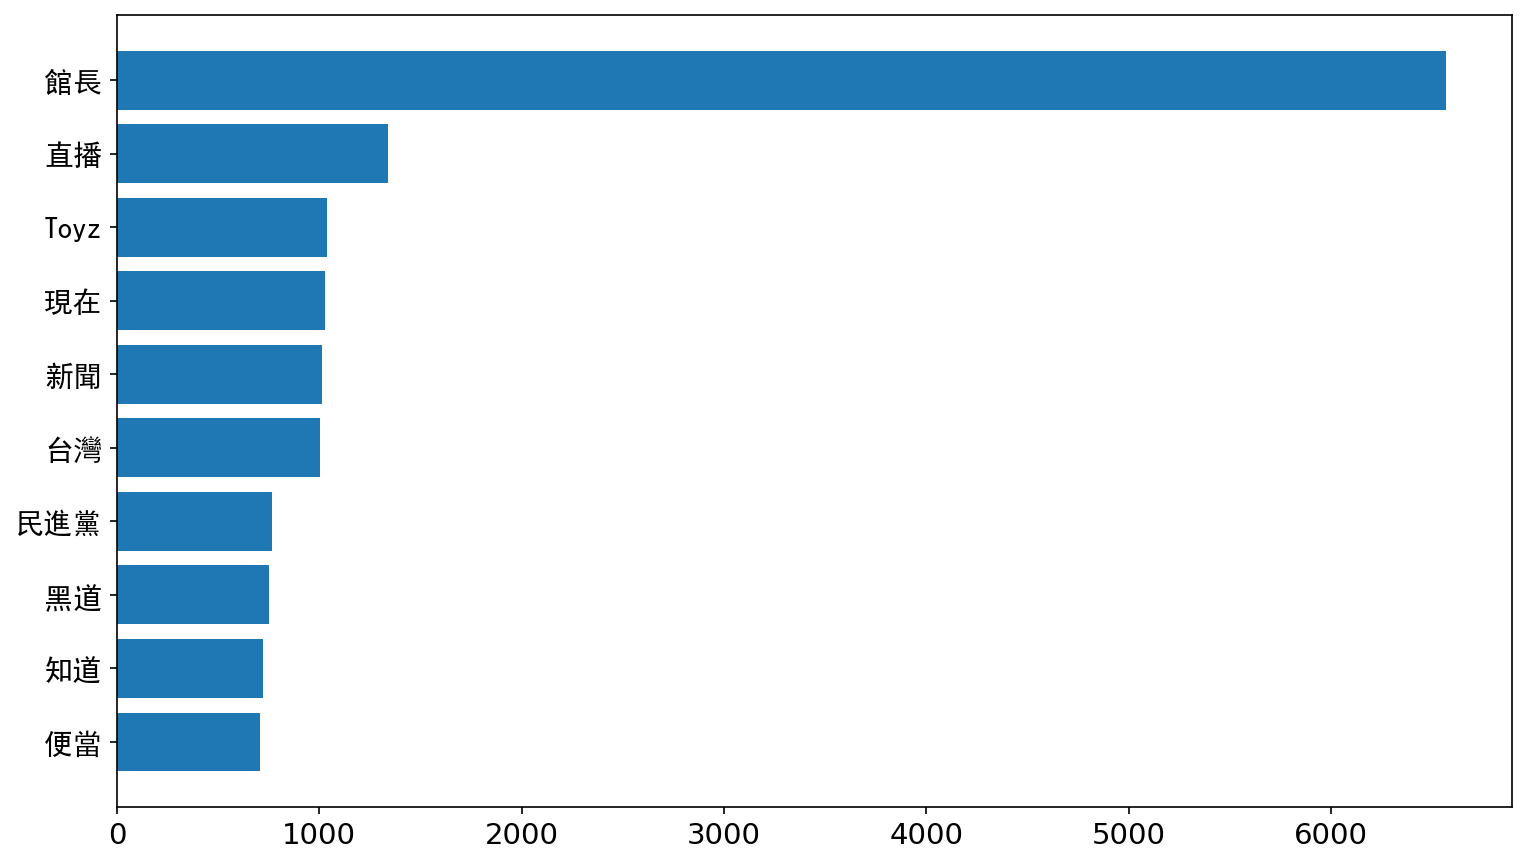

In [38]:
fontPath = "./raw_data/SimHei.ttf"
fprop = fm.FontProperties(fname=fontPath)

fig, ax = plt.subplots(figsize =(12, 7))
# 設定中文字形
plt.rcParams['font.sans-serif'] = ['TaipeiSansTCBeta-Regular']
x = freq_df.iloc[:10]['freq']
y = freq_df.iloc[:10]['word']

ax.barh(y, x)
ax.set_yticklabels(y, fontproperties=fprop)
ax.invert_yaxis()
fig.show()

#### 1-6. 文字雲

In [40]:
freq_df = pd.DataFrame({'freq':noStop_df.groupby(['word']).size().sort_values(ascending=False)}).reset_index(drop = False)

clist = ['word','freq']
freq_df = freq_df[clist]
freq_df

word  freq
0        館長  6566
1        直播  1339
2      Toyz  1038
3        現在  1028
4        新聞  1011
...     ...   ...
35020    晉升     1
35021    晉豪     1
35022   晚一場     1
35023   晚九點     1
35024  找四叉貓     1

[35025 rows x 2 columns]

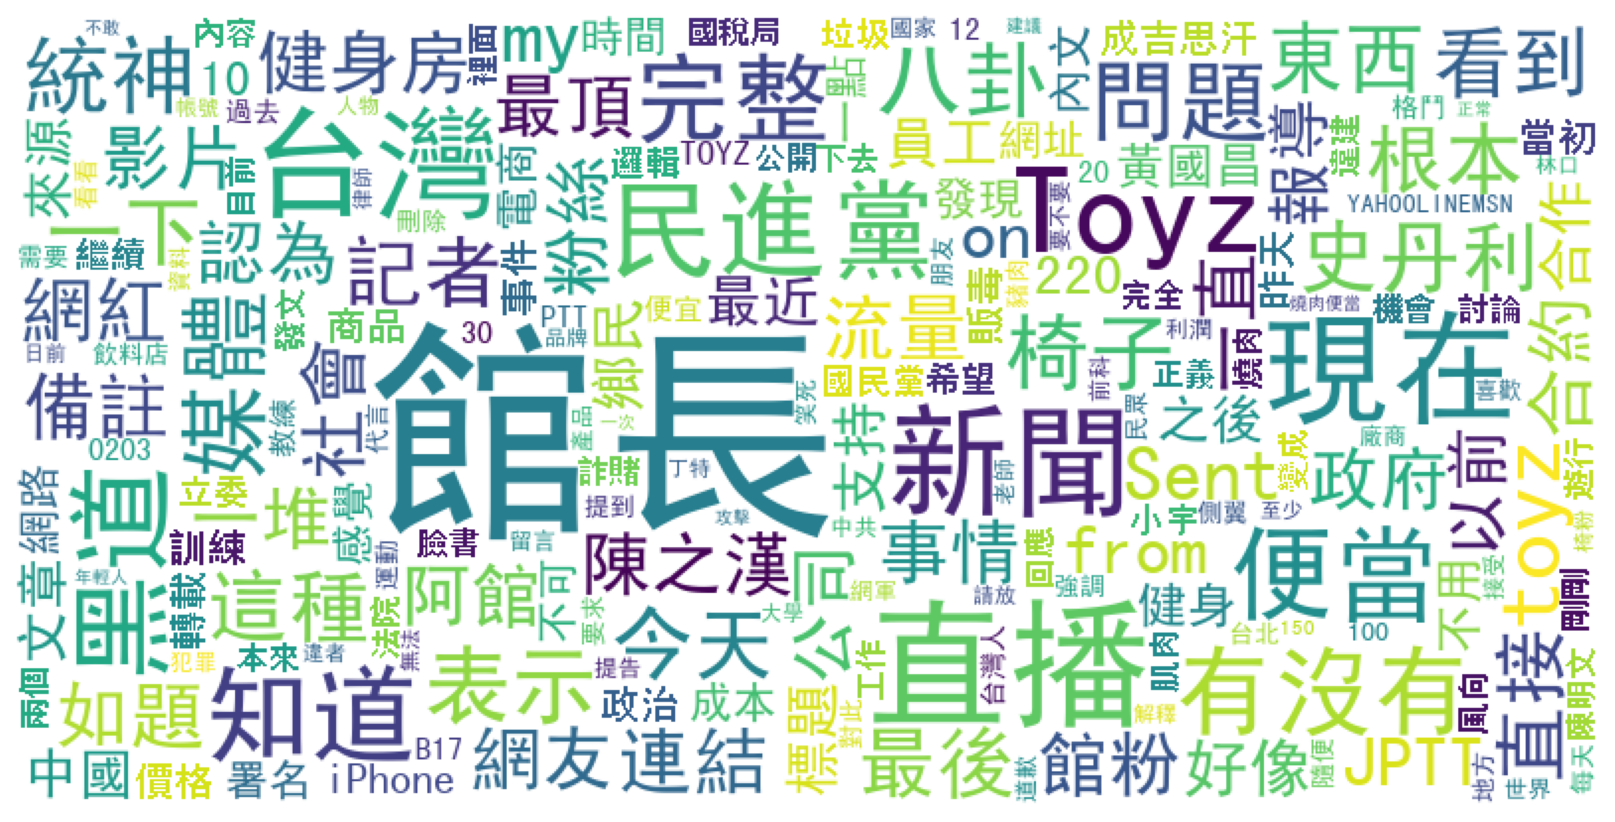

In [41]:
# 詞頻變成dict
freq_dict = freq_df.set_index('word', inplace=False).to_dict()
freq_dict = freq_dict['freq']

# 繪製文字雲
wordcloud = WordCloud(background_color='white', width=800, height = 400, font_path=fontPath, max_words=200)
wordcloud.generate_from_frequencies(freq_dict)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

我們可以看到大部分出現的詞語是關於館長或是Toyz事件中常出現的特定字眼，也有些是雙方攻擊對方的字詞，發現戰火已經掃到其他議題上，兩方在爭論當中已經不止於合約、代言、健身與格鬥，而是包括販毒、黨爭、黑道、立委。

### 2. ckip

#### 2-1. CKIP 處理相關function

In [43]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    final_res = []
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    
    paragraphs = list(filter(None, str(article).split("\n")))
    #paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
    #print(len(paragraphs))
    #print(paragraphs)
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            _logger.info("error")
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

In [44]:
# 自定義辭典
with open('./dict/dict.txt') as f:
    lines = f.read().splitlines()

dictionary2 = {k.split()[0]: k.split()[1] for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dictionary2)
print(dictionary2)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [45]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
#     print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id,word,pos]) 
#         print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
#     print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3],entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    for index, row in data_df.iterrows(): # document level    
#         print(f"\ndocument {index}") 

        # clean data
        result = [] 
        tmp = Sentence_Segmentation(row['artContent']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2) # set dictionary 
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        for i, sentence in enumerate(flat_list): # sentence level
#             print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'],sentence])            
            temp_tokens = get_pos(row['system_id'],word_sentence_list[i],  pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'],entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [46]:
# 看看tmp和flat_list有什麼差別
tmp = Sentence_Segmentation(df['artContent'][0]) 
flat_list = [item for sublist in tmp for item in sublist]
print(tmp[:5])
print(flat_list[:5])

[['我是想件事很不明白'], ['照阿館所說'], ['對阿館開槍的背後真的是當今朝廷'], ['有點不合理呀'], ['因為當初年的時候']]
['我是想件事很不明白', '照阿館所說', '對阿館開槍的背後真的是當今朝廷', '有點不合理呀', '因為當初年的時候']


In [47]:
pos_table, entity_table, sentence_table = get_nlp_result(df)

Exception ignored in: <bound method WS.__del__ of <ckiptagger.api.WS object at 0x7f1afc3eb358>>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/ckiptagger/api.py", line 56, in __del__
    self.model.sess.close()
AttributeError: 'WS' object has no attribute 'model'


time costing: 523.2084307670593


In [48]:
pos_table.head() # word pos 列表

system_id word  pos
0          1    我   Nh
1          1    是  SHI
2          1    想   VE
3          1    件   Nf
4          1    事   Na

In [49]:
entity_table.head() # word entity 列表

system_id word       ner
0          1  候阿館       FAC
1          1   香港       GPE
2          2    漢    PERSON
3          2    三  CARDINAL
4          3  黃朝郁    PERSON

In [50]:
sentence_table.head()

system_id         sentence
0          1        我是想件事很不明白
1          1            照阿館所說
2          1  對阿館開槍的背後真的是當今朝廷
3          1           有點不合理呀
4          1         因為當初年的時候

In [51]:
# 檢查筆數
print(f"total posts numbers: {len(pos_table['system_id'].unique())}") # 1628篇文
print(f"posts have NER: {len(entity_table['system_id'].unique())}") # 1620篇有抓到ner

total posts numbers: 3151
posts have NER: 2426


#### 2-2. 探索分析 - NER

##### NER 種類分析

In [59]:
entity_table['ner'].unique()

array(['FAC', 'GPE', 'PERSON', 'CARDINAL', 'DATE', 'ORG', 'TIME', 'MONEY',
       'LOC', 'NORP', 'QUANTITY', 'ORDINAL', 'EVENT', 'LANGUAGE',
       'WORK_OF_ART', 'PRODUCT', 'LAW'], dtype=object)

In [57]:
ner_count = entity_table.groupby(['ner'])['ner'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(8)
ner_count

ner  count
12    PERSON   4613
4        GPE   2641
0   CARDINAL   2378
1       DATE   2226
11       ORG   1504
9       NORP    367
10   ORDINAL    273
8      MONEY    273

/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


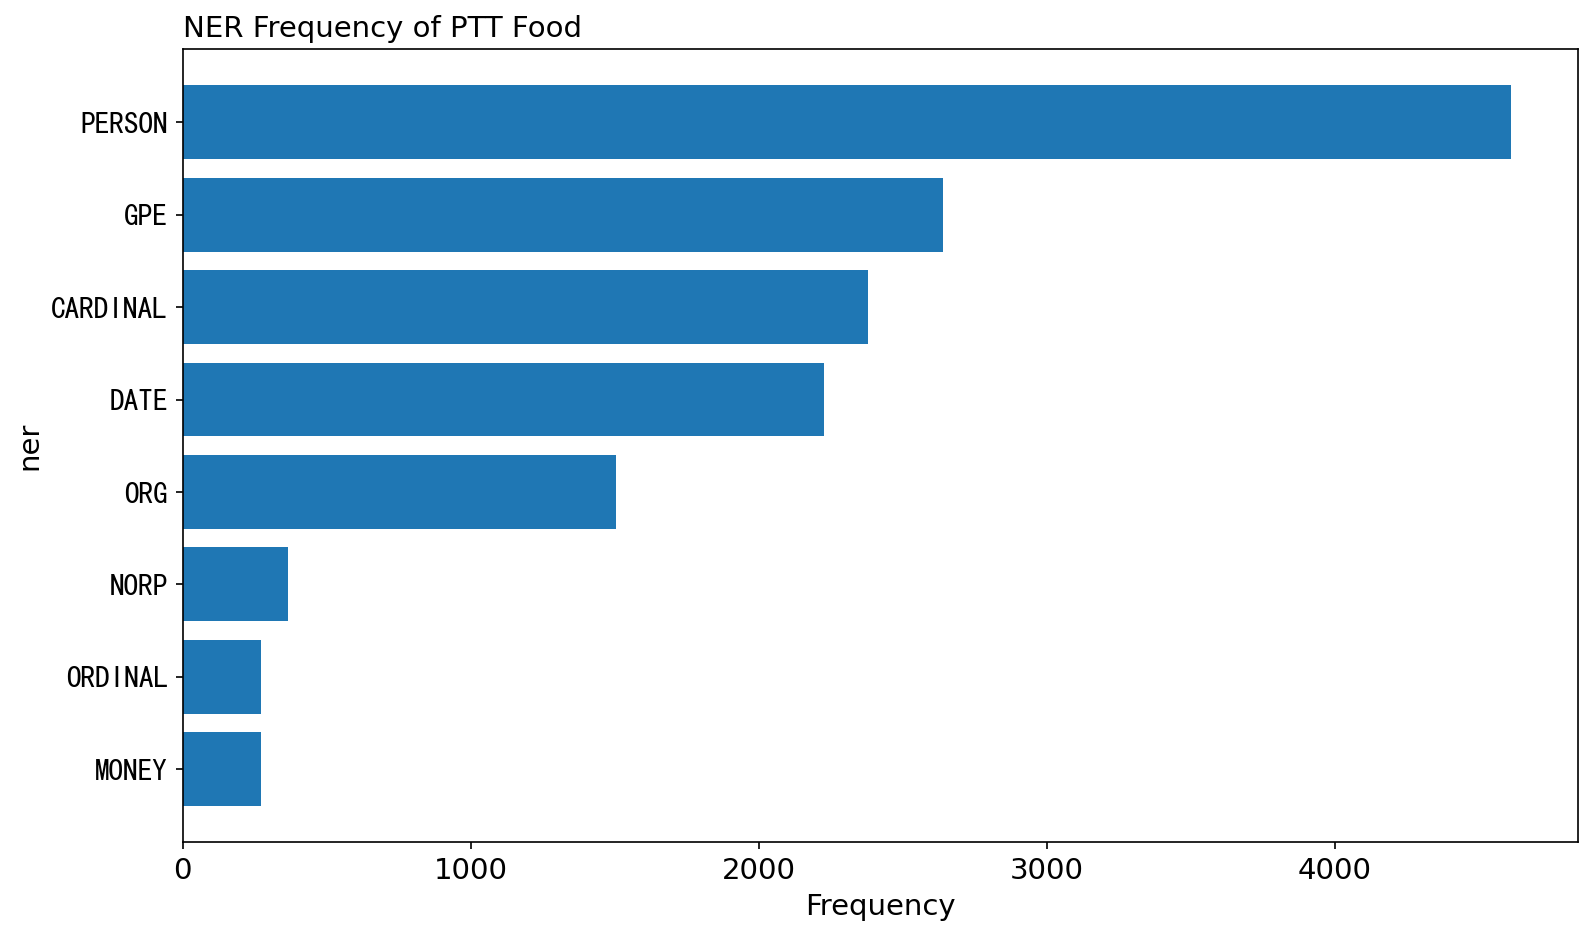

In [58]:
ner = ner_count['ner']
count = ner_count['count']
plt.rcParams['font.sans-serif'] = ['TaipeiSansTCBeta-Regular']
fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(ner, count)
ax.set_yticklabels(ner, fontproperties=fprop)
ax.invert_yaxis()
ax.set_title('NER Frequency of PTT Food',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

在我們利用ckip之後，可以看到出現最多的是人名再來是國家

#### 2-3. 涉及到的人名(PERSON)
網友談論的不僅是當事人: 館長(陳之漢)與Toyz(劉偉健)，還有立委、市長、總統等。

在Person entity 當中，也出現了館長陳之漢的名字，以及雙方吵架當中所提及的政治人物名字，可見網路上也同樣會討論網路名人討論的這些政治人物

/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


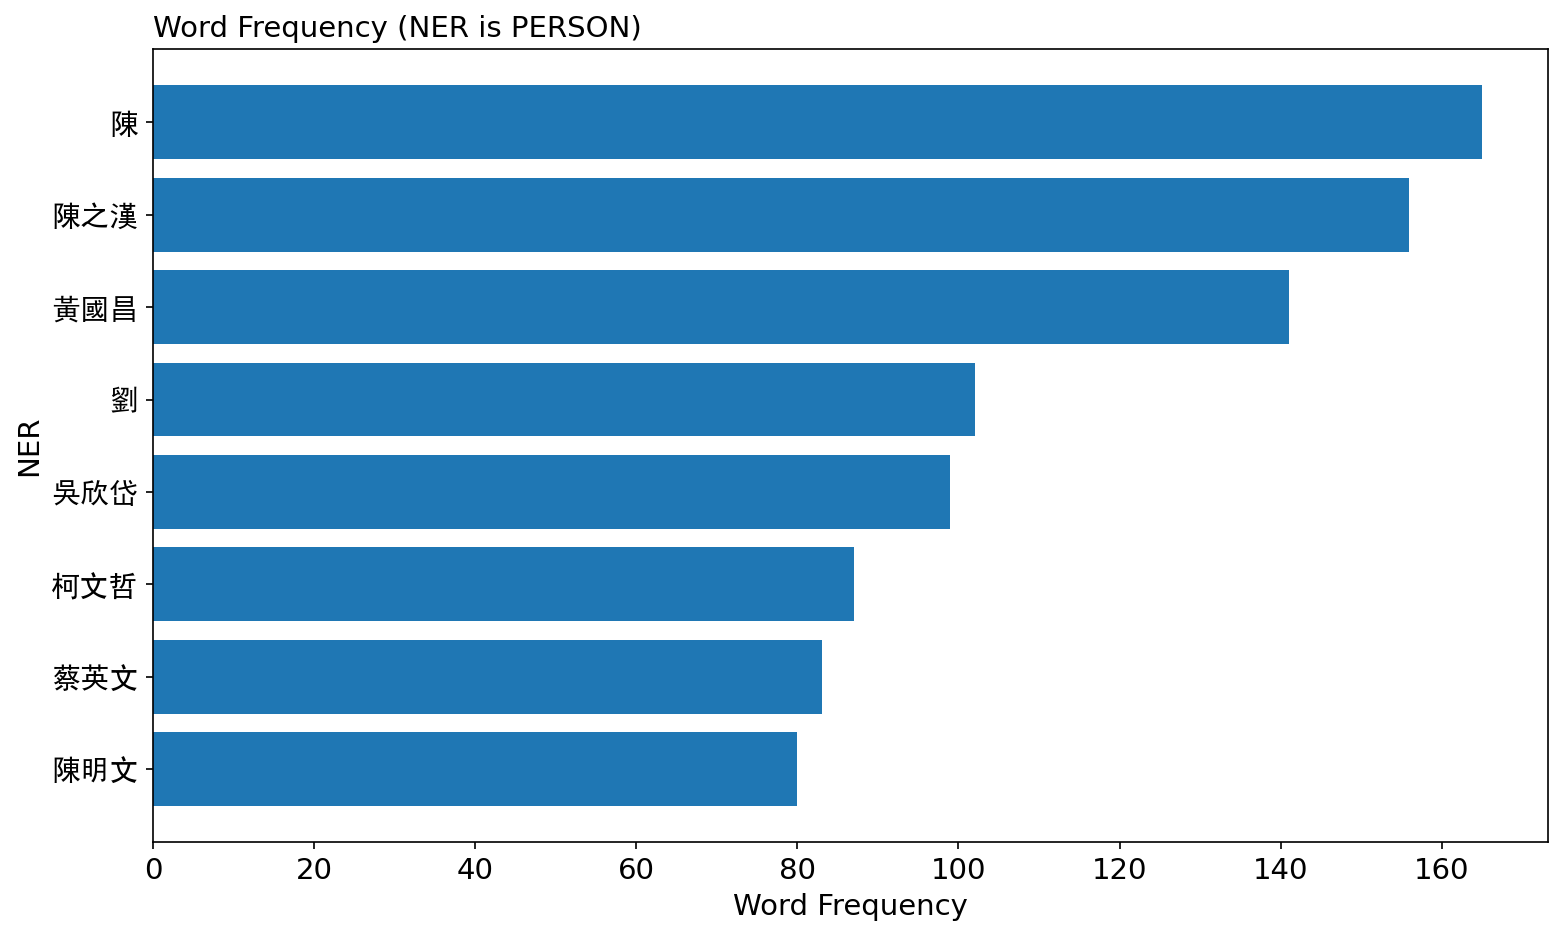

In [60]:
# 篩選ner為名詞的資料
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前8個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(8).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['TaipeiSansTCBeta-Regular']
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.set_yticklabels(word, fontproperties=fprop)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

#### 2-4. 涉及到的國家(GPE)
事件主要發生在台灣。

/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


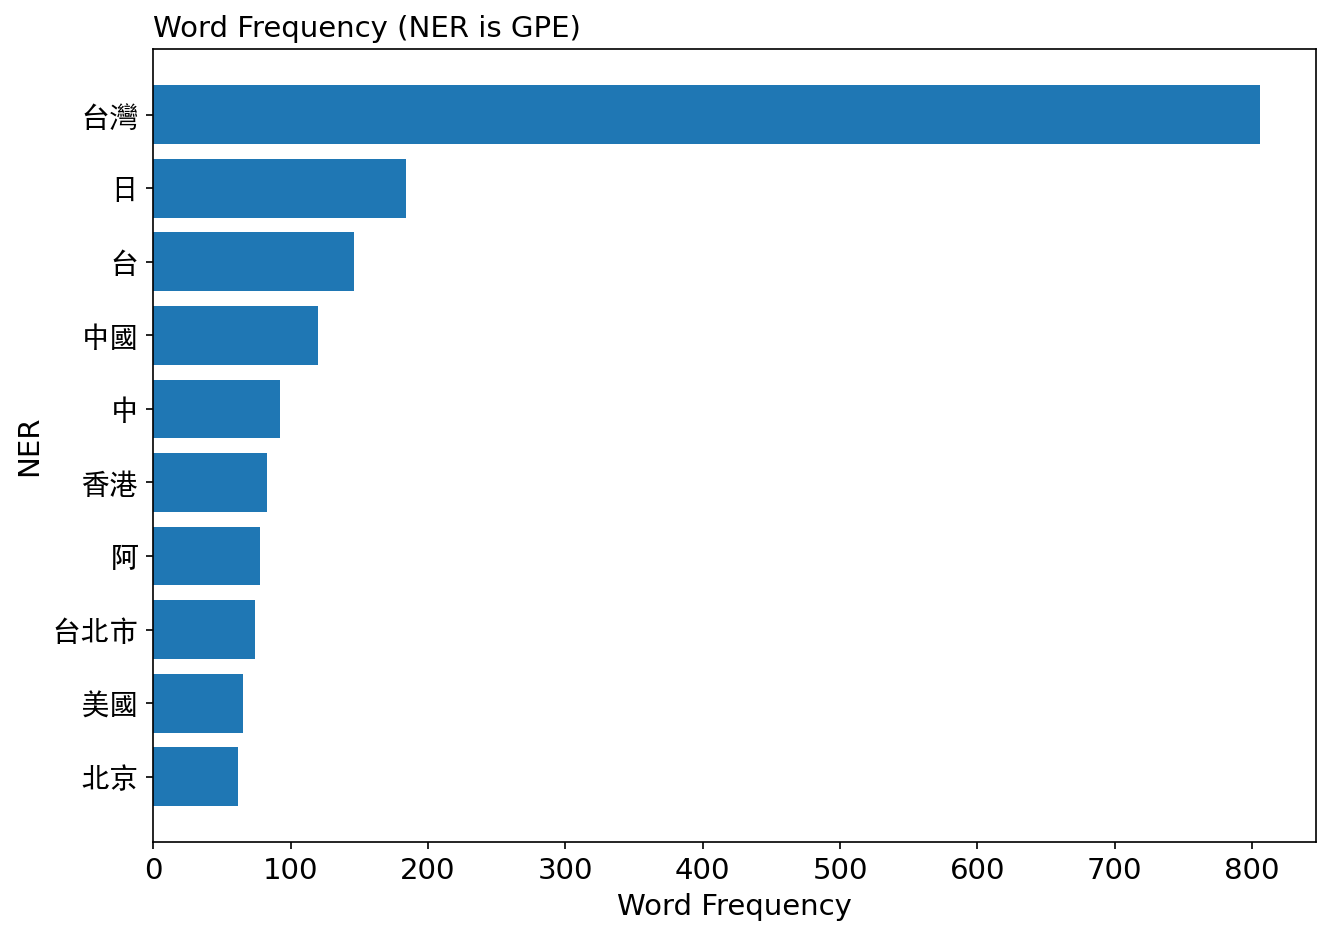

In [61]:
# 篩選ner為名詞的資料
l_noun = ["GPE"]
GPE = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = GPE.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['TaipeiSansTCBeta-Regular']
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.set_yticklabels(word, fontproperties=fprop)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is GPE)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

### 涉及到的民族、宗教、政治團體(ORG)

#### 2-5. 涉及到的組織(ORG)

這邊出現了一些比較有趣的發現，例如政治黨派、英雄聯盟、竹聯幫等團體，也是跟我們這次要談論的兩個人有大大的關係，也同樣會被鄉民拿出來加入討論。

/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


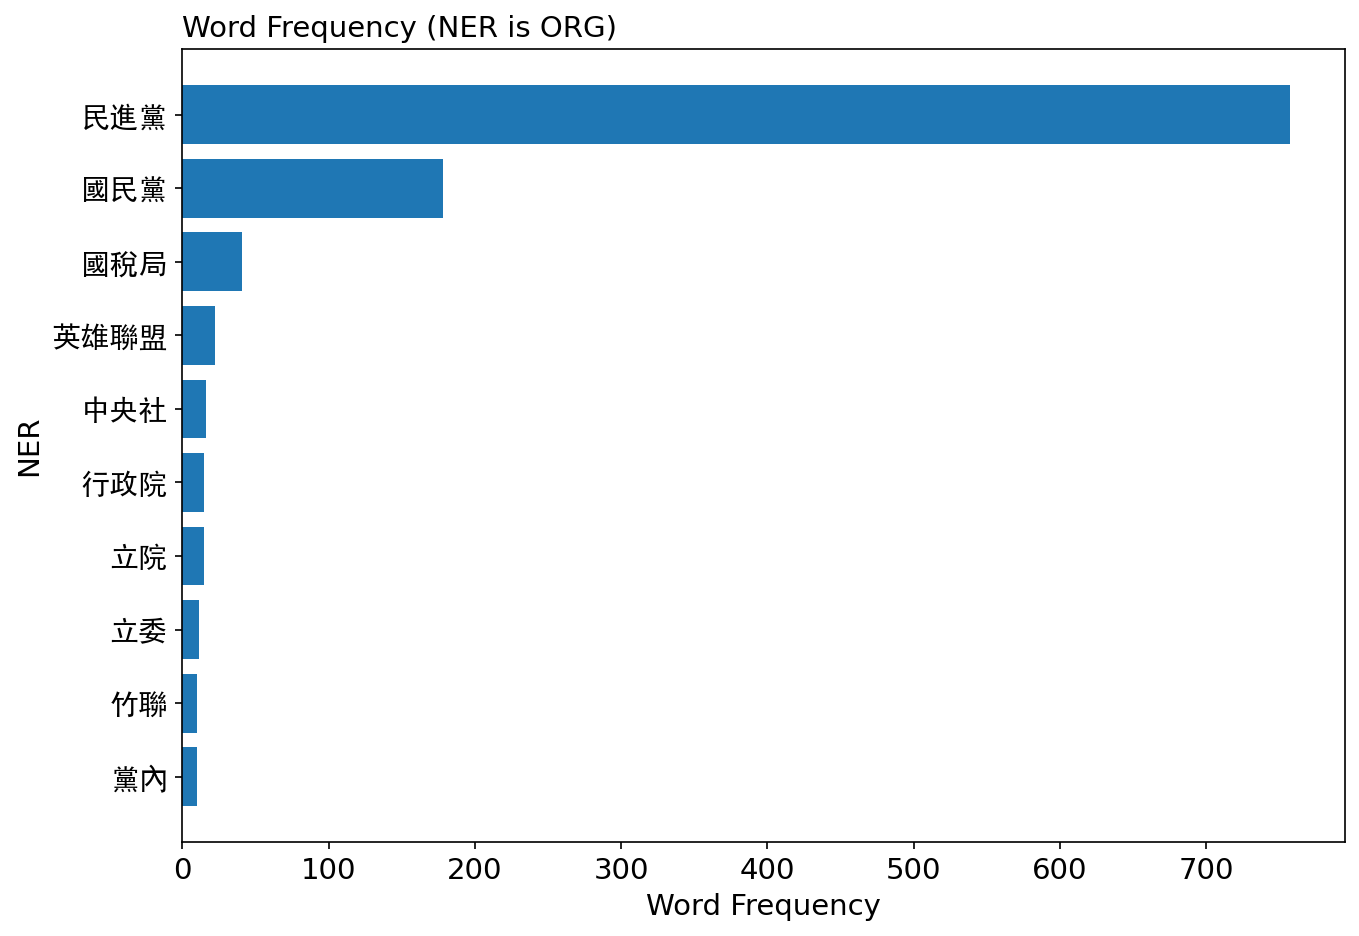

In [62]:
# 篩選ner為名詞的資料
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['TaipeiSansTCBeta-Regular']
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.set_yticklabels(word, fontproperties=fprop)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


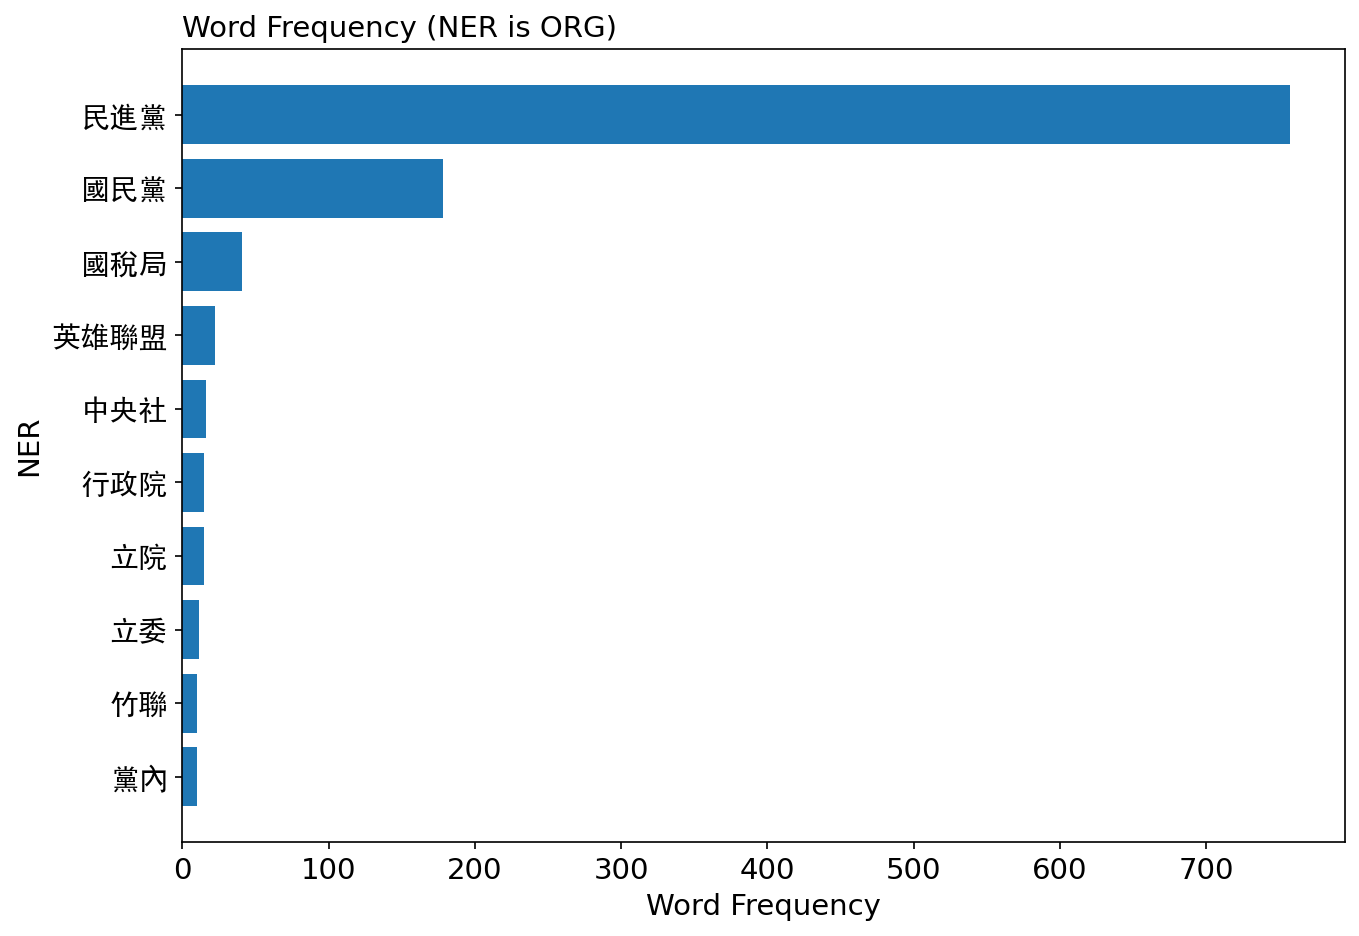

In [63]:
# 篩選ner為名詞的資料
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['TaipeiSansTCBeta-Regular']
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.set_yticklabels(word, fontproperties=fprop)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

陳之漢 關鍵字

#### 2-6. 使用NER得到的「陳之漢」相關文章

Toyz 關鍵字

In [133]:
df['artContent'] = df['artContent'].fillna('').str.strip()
keyword_list2 = ['Toyz']
toyz_selected = df[df['artContent'].str.contains('|'.join(keyword_list2),regex=True)]
print(f"{' '.join(keyword_list2)}：{toyz_selected.shape[0]}篇相關貼文")
toyz_selected.head(3)

Toyz：360篇相關貼文


system_id                                             artUrl  \
188        189  https://www.ptt.cc/bbs/Gossiping/M.1670045891....   
352        353  https://www.ptt.cc/bbs/Gossiping/M.1670486896....   
396        397  https://www.ptt.cc/bbs/Gossiping/M.1670686027....   

                 artTitle              artDate    artPoster artCatagory  \
188       [問卦]館長是不是死亡直播啊？  2022-12-03 13:38:09      tyo5151   Gossiping   
352  [問卦]Toyz會邀請烏鴉上他的節目嗎？  2022-12-08 16:08:14     h2030625   Gossiping   
396    [問卦]如果有Toyz與統神兄弟影集  2022-12-10 23:27:05  AngelsDemon   Gossiping   

                                            artContent  \
188  2018.4  Tao直播訪談\n2018.7  自強隧道飆車競速 間接導致2死3傷的車禍意...   
352  烏鴉現在被逮捕了之後也可能要坐牢\n\nToyz不知道會不會邀請烏鴉\n\n上他的節目像Gi...   
396  各位肥宅安安\n\n剛剛跟朋友聊天聊到網飛\n\n如果網飛出一個Toyz跟統神兄弟的影集\n...   

                                            artComment             e_ip  \
188  [{"cmtStatus": "→", "cmtPoster": "johnwu", "cm...  223.136.239.195   
352  [{"cmtStatus": "噓", "cmtPoster": "Usayhiisayha...    111.82.128.56   
396  [{"cmtStatus": "噓", "cmtPoster": "deepdish", "...  210.208.106.157   

            insertedDate dataSource  
188  2022-12-04 01:28:22        ptt  
352  2022-12-09 01:32:43        ptt  
396  2022-12-11 01:35:30        ptt

In [154]:
df['artContent'] = df['artContent'].fillna('').str.strip()
keyword_list = ['陳之漢']
strong_selected = df[df['artContent'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{strong_selected.shape[0]}篇相關貼文")
strong_selected.head(3)

陳之漢：206篇相關貼文


system_id                                             artUrl  \
2           3  https://www.ptt.cc/bbs/Gossiping/M.1669855917....   
41         42  https://www.ptt.cc/bbs/Gossiping/M.1669904929....   
49         50  https://www.ptt.cc/bbs/Gossiping/M.1669910723....   

                                 artTitle              artDate     artPoster  \
2                  [新聞]館長開戰！直播公布「陳明文委員」電話  2022-12-01 08:51:54   silence0930   
41                [新聞]「綠營高層沒救都黑道」館長公布陳明文通  2022-12-01 22:28:46    FastGunMan   
49  [新聞]合體黃國昌揭槍擊案背後「綠色影子」館長批黑道治國：連蔡英文也被架空  2022-12-02 00:05:20  kenny1300175   

   artCatagory                                         artContent  \
2    Gossiping  1.媒體來源:\n中時\n\n2.記者署名:\n黃朝郁\n\n3.完整新聞標題:\n館長開戰...   
41   Gossiping  1.媒體來源:\n聯合報\n\n2.記者署名:\n侯俐安\n\n3.完整新聞標題:\n「綠營...   
49   Gossiping  備註請放最後面 違者新聞文章刪除\n\n1.媒體來源: 風傳媒\n2.記者署名: 陳嬿婷\n...   

                                           artComment             e_ip  \
2   [{"cmtStatus": "推", "cmtPoster": "AndyZer", "c...    114.38.35.178   
41  [{"cmtStatus": "推", "cmtPoster": "KadourZiani"...   36.226.119.105   
49  [{"cmtStatus": "→", "cmtPoster": "a27588679", ...  118.166.157.177   

           insertedDate dataSource  
2   2022-12-02 01:28:38        ptt  
41  2022-12-02 01:34:51        ptt  
49  2022-12-02 01:35:35        ptt

### 3.3 探索分析 - POS

#### POS 種類分析

#### 2-7. 探索分析 - POS

In [65]:
pos_table['pos'].unique()

array(['Nh', 'SHI', 'VE', 'Nf', 'Na', 'Dfa', 'D', 'VH', 'P', 'Nc', 'VC',
       'DE', 'Ncd', 'Nd', 'V_2', 'T', 'Cbb', 'VG', 'Nes', 'VD', 'VJ',
       'Nep', 'Da', 'Di', 'VF', 'Ng', 'VHC', 'VK', 'Neqa', 'Nb', 'VL',
       'VA', 'VCL', 'I', 'COMMACATEGORY', 'FW', 'Dfb', 'Caa', 'Neu', 'A',
       'Dk', 'COLONCATEGORY', 'VB', 'Cab', 'VI', 'Nv', 'VAC', 'Neqb',
       'PERIODCATEGORY', 'SEMICOLONCATEGORY', 'PARENTHESISCATEGORY',
       'Cba', 'DASHCATEGORY', 'ETCCATEGORY', 'DM'], dtype=object)

看看除了標點符號，大部分的POS都是哪一類

/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


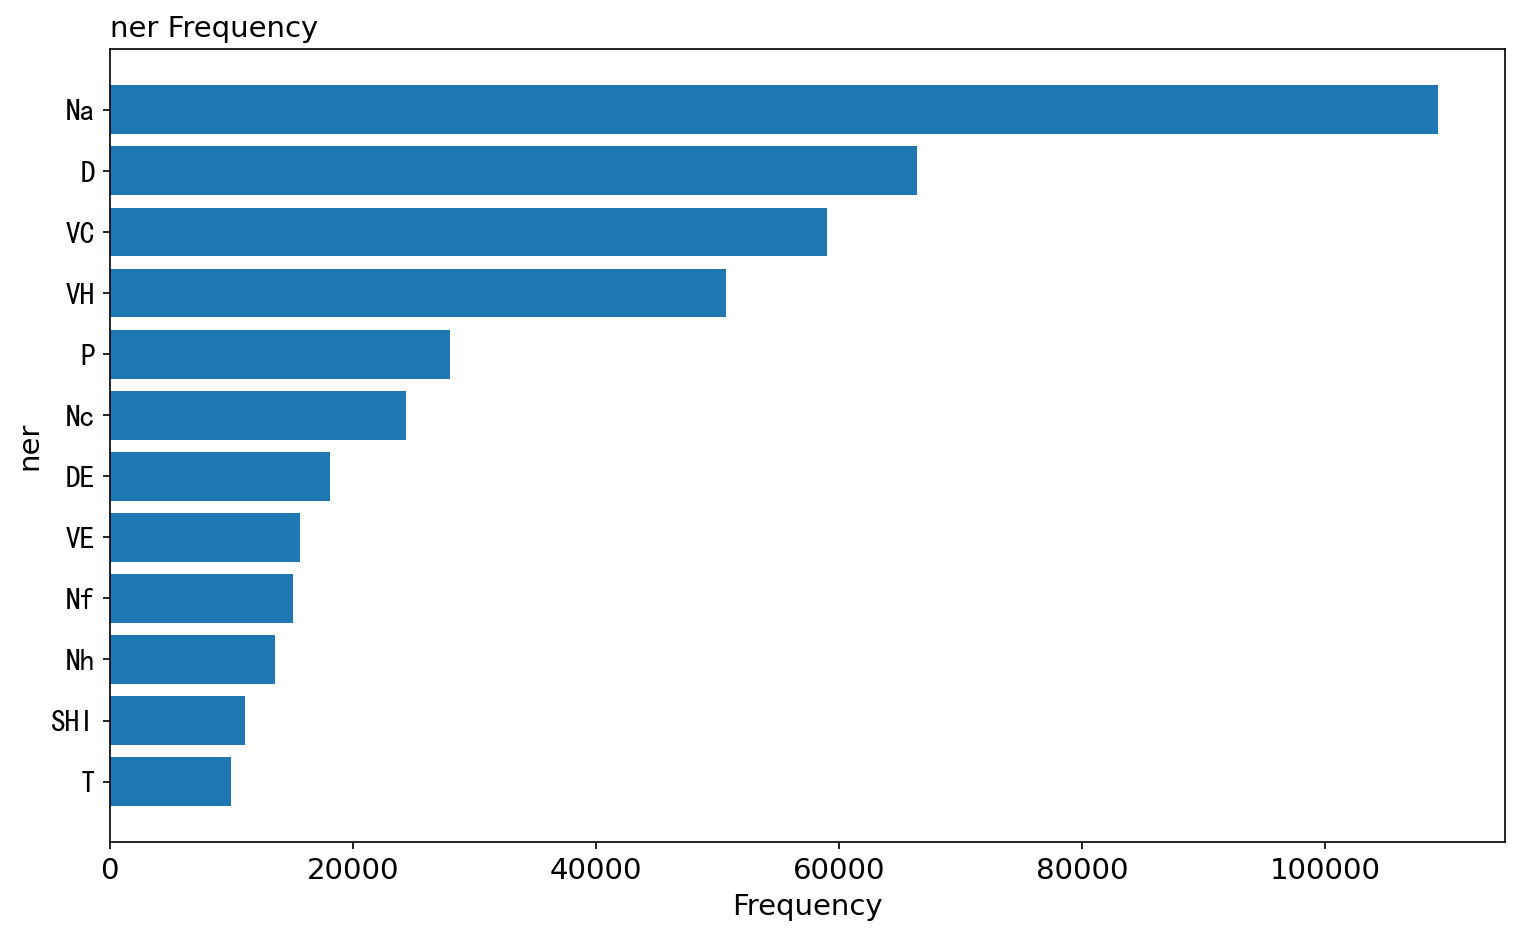

In [72]:
plt.rcParams['font.sans-serif'] = ['TaipeiSansTCBeta-Regular']
pos = pos_count['pos']
count = pos_count['count']
fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(pos, count)
ax.set_yticklabels(pos, fontproperties=fprop)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

### 涉及到的名詞(Noun)

#### 2-8. 名詞(Na)

In [74]:
# 篩選pos為名詞的資料
l_noun = ["Na"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前15個
noun_count = noun[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
noun_count.head(10)

word  count
42      人   6197
35      事   1801
696     文   1449
399     子   1329
1810    身   1258
90      們   1234
1851    道   1225
1907    錢   1132
1696    話   1088
1396    者   1020

/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


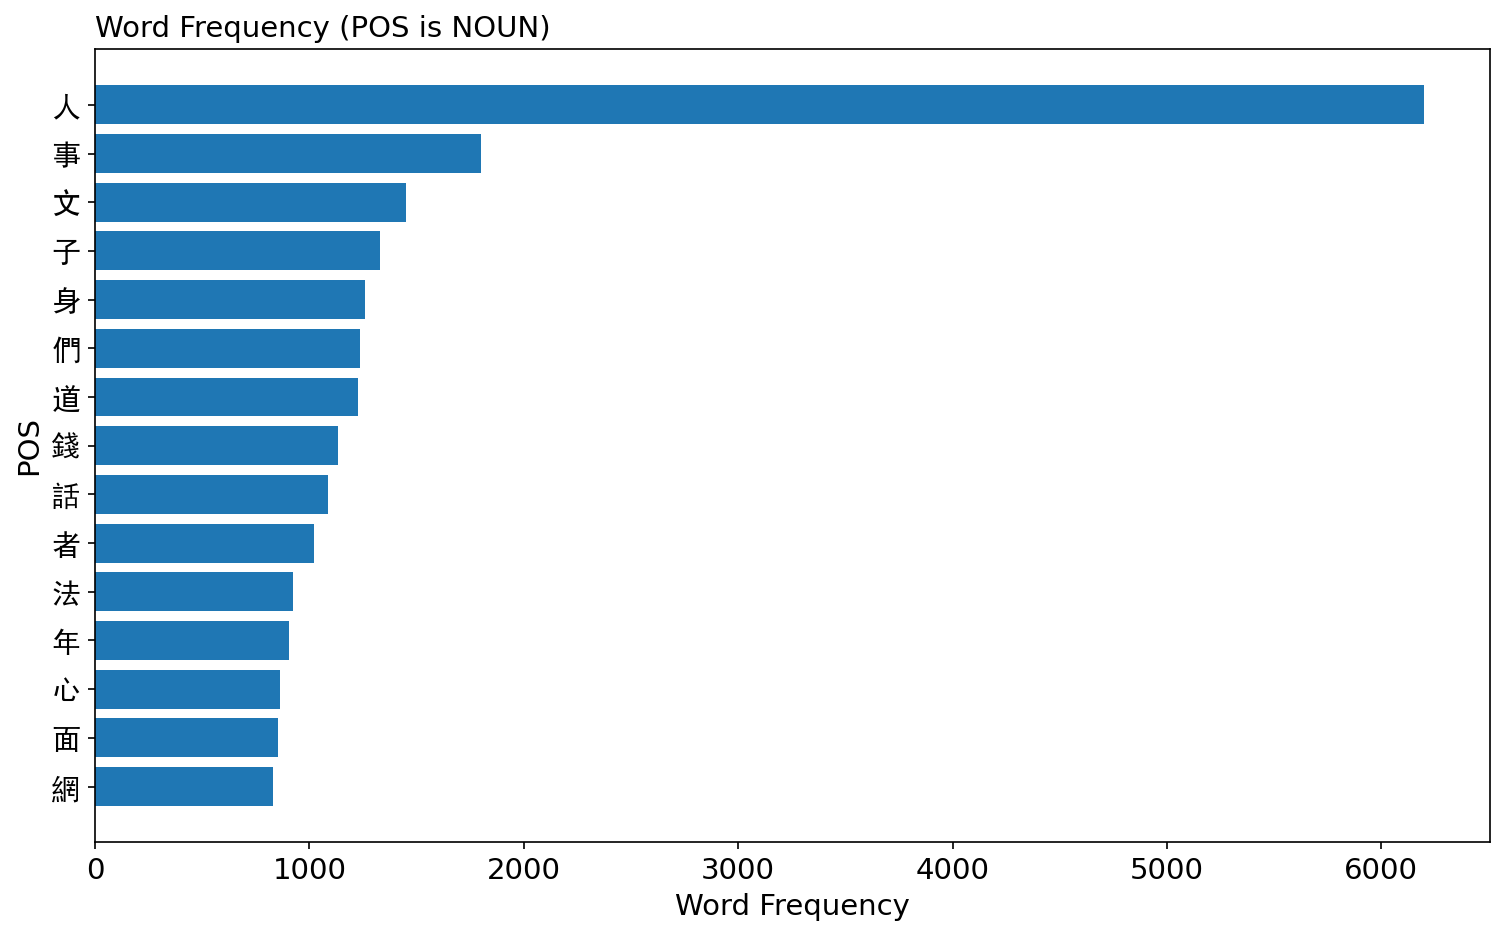

In [75]:
# 設定中文字形
plt.rcParams['font.sans-serif'] = ['TaipeiSansTCBeta-Regular']
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.set_yticklabels(word, fontproperties=fprop)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

### 涉及到的動詞(VERB)

#### 2-9. 動詞(Vc)

In [81]:
l_verb = ["VC"] # ,"VH","VA"
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
verb_count

word  count
110   支持    232
114   攻擊    117
71    引發     93
193   製作     70
24    加入     70
222   進行     69
91    推出     69
73    影響     67
123   服務     59
152   發展     58
199   解決     58
185   舉辦     57
217   辦理     50
200   訓練     49
49    完成     49

## LIWC

### 3. 情緒分析

In [88]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

word sentiments
0   ):     affect
1   3q     affect
2   :(     affect
3   :)     affect
4   <3     affect

#### 3-1. 留言熱度
從每天的發言數量可以看出，事件主要發生在2022年末到2023年初，原有下降趨勢，而最近熱度又開始回升。

In [92]:
ptt_df["artDate"].describe(datetime_is_numeric=True)

count                           197492
mean     2023-02-04 11:23:49.926579456
min                2022-12-01 00:01:35
25%                2022-12-22 09:56:40
50%                2023-02-02 00:54:51
75%                2023-03-24 16:40:12
max                2023-04-17 22:12:26
Name: artDate, dtype: object

In [93]:
ptt_df["artDate"] = ptt_df["artDate"].dt.date

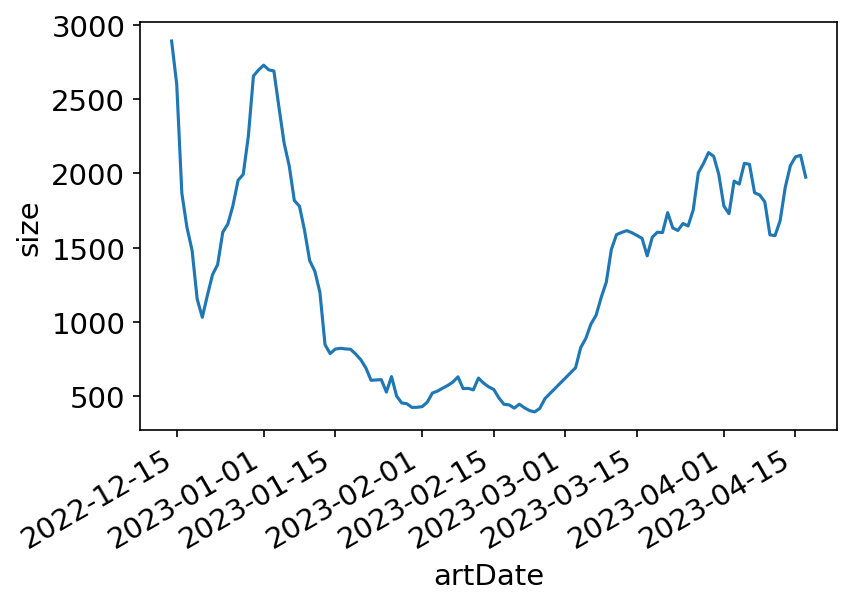

In [94]:
ptt_line_plot = ptt_df.groupby(["artDate"], as_index=False).size()

fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_line_plot["artDate"], ptt_line_plot["size"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel('size')
fig.autofmt_xdate()
plt.show()

可以看到年初雙方因為第一次練拳開戰，網路上的文章討論數量大大提升，中間砲火停息了一端時間，發文量急遽減低，直到3 4月又開始吵其來，可以看到網路上的人也開始議論紛紛

#### 3-2. 情緒字典與斷詞結果進行合併
將情緒字典與斷詞結果進行合併。

In [95]:
ptt_liwc_df = pd.merge(ptt_df[["artDate", "artUrl", "word"]], liwc_dict, how="left")
ptt_liwc_df

artDate                                             artUrl    word  \
0       2022-12-01  https://www.ptt.cc/bbs/Gossiping/M.1669824097....      一件   
1       2022-12-01  https://www.ptt.cc/bbs/Gossiping/M.1669824097....      明白   
2       2022-12-01  https://www.ptt.cc/bbs/Gossiping/M.1669824097....      阿館   
3       2022-12-01  https://www.ptt.cc/bbs/Gossiping/M.1669824097....      阿館   
4       2022-12-01  https://www.ptt.cc/bbs/Gossiping/M.1669824097....      開槍   
...            ...                                                ...     ...   
212050  2023-04-17  https://www.ptt.cc/bbs/Gossiping/M.1681740749....      my   
212051  2023-04-17  https://www.ptt.cc/bbs/Gossiping/M.1681740749....  iPhone   
212052  2023-04-17  https://www.ptt.cc/bbs/Gossiping/M.1681740749....      11   
212053  2023-04-17  https://www.ptt.cc/bbs/Gossiping/M.1681740749....     Pro   
212054  2023-04-17  https://www.ptt.cc/bbs/Gossiping/M.1681740749....     Max   

       sentiments  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN  
...           ...  
212050        NaN  
212051        NaN  
212052        NaN  
212053        NaN  
212054        NaN  

[212055 rows x 4 columns]

#### 3-3. 正負向情緒分數聲量折線圖
從情緒分數分布中意外發現，原本以為爭論相關議題會是壓倒性的負面情緒，但是討論版上正面與負面情緒相當，可見還是將近半數的貼文是採樂觀態度。

In [96]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"], dropna=False, as_index=False).size()
)
sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count

artDate sentiments  size
0    2022-12-01     affect   221
1    2022-12-01      anger    47
2    2022-12-01        anx    16
3    2022-12-01   negative   115
4    2022-12-01   positive    91
..          ...        ...   ...
854  2023-04-17        sad     6
850  2023-04-17      anger    33
849  2023-04-17     affect   161
851  2023-04-17        anx     1
855  2023-04-17        NaN  2307

[856 rows x 3 columns]

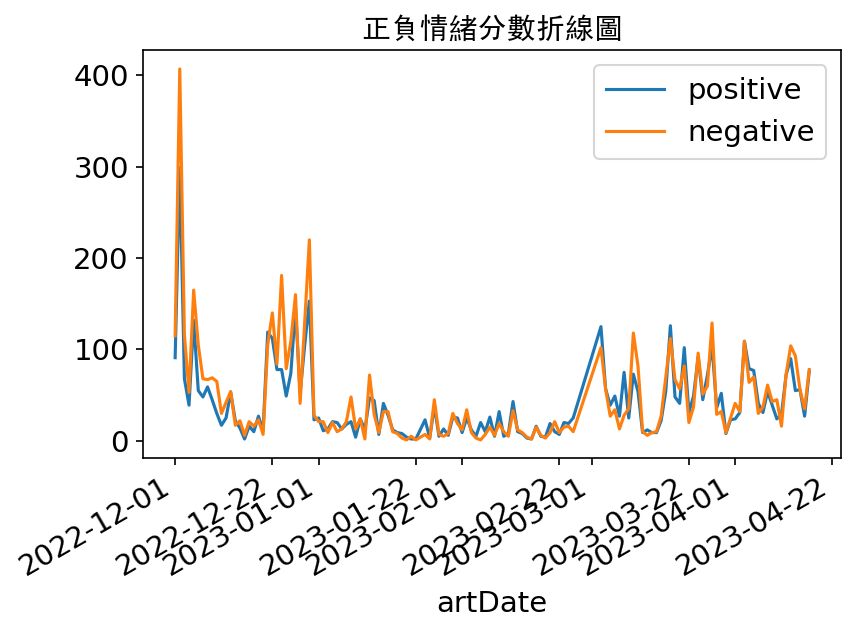

In [97]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

ax.plot(pos["artDate"], pos["size"], color=colors[0])
ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒分數折線圖", 
          fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

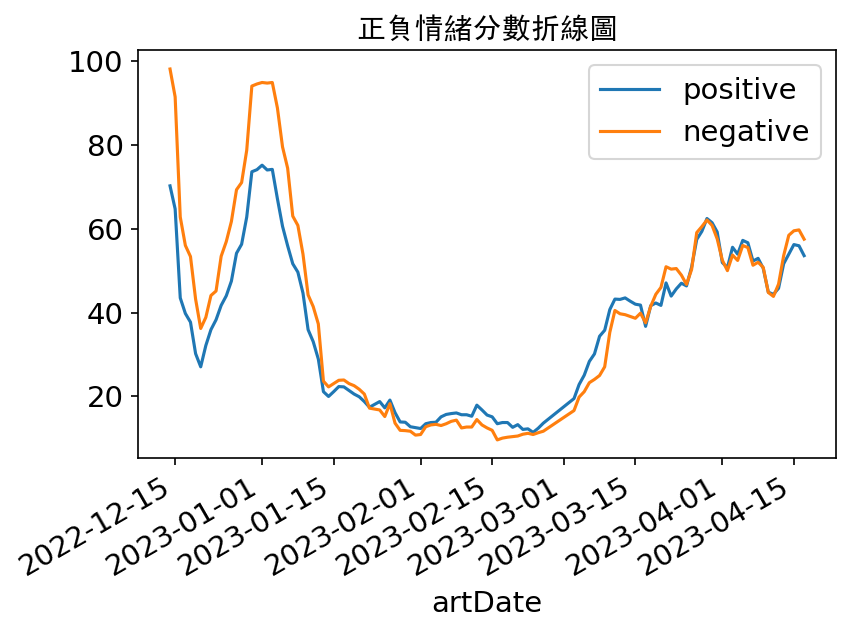

In [98]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天移動平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒分數折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

#### 3-4. 正負向情緒分數比例折線圖
對照先前每日的留言熱度，意外發現文章數較少的時期，內容轉向明顯正面，且後來也是正面比例較高，反映民視新聞網所述:「粉絲們倒是看得超級開心，紛紛留言敲碗求續集！」  
資料來源: [民視新聞網 - 「館椅大戰」到底吵啥？15小時濃縮15分鐘懶人包　粉絲爽讚：求續集](https://www.ftvnews.com.tw/news/detail/2023314W0253)

In [99]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)
sentiment_count

artDate sentiments  size     ratio
0    2022-12-01     affect   221  0.045661
1    2022-12-01      anger    47  0.009711
2    2022-12-01        anx    16  0.003306
3    2022-12-01   negative   115  0.023760
4    2022-12-01   positive    91  0.018802
..          ...        ...   ...       ...
854  2023-04-17        sad     6  0.002254
850  2023-04-17      anger    33  0.012397
849  2023-04-17     affect   161  0.060481
851  2023-04-17        anx     1  0.000376
855  2023-04-17        NaN  2307  0.866642

[856 rows x 4 columns]

In [100]:
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

Text(0.5, 1.0, '正負情緒比例折線圖')

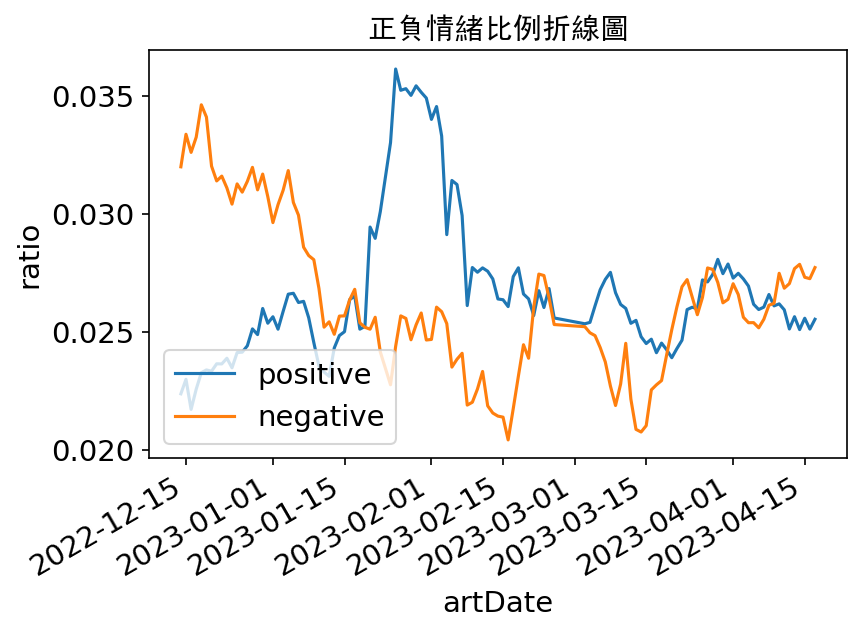

In [101]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖", fontproperties=fprop)

#### 3-5. 情緒文字雲
針對不同日期畫出該天的文字雲，如果文字雲中的字詞大小越大，代表出現頻率越高。

In [102]:
mask = sentiment_count['sentiments'] == 'positive'
sentiment_count.loc[mask,:].sort_values("size", ascending=False).head()

artDate sentiments  size     ratio
11   2022-12-02   positive   299  0.026100
201  2022-12-30   positive   153  0.023747
180  2022-12-27   positive   146  0.032765
32   2022-12-05   positive   132  0.021750
648  2023-03-18   positive   126  0.028702

##### 2023-03-03 文字雲
2023-03-03 是**負面**面詞彙的一天。我們可以用文字雲來觀察。

In [103]:
date = "2023-03-03"
mask = (ptt_liwc_df['artDate'] == pd.Timestamp(date))
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

[('館長', 147),
 ('便當', 54),
 ('0303', 43),
 ('Toyz', 41),
 ('220', 29),
 ('台灣', 22),
 ('問題', 22),
 ('違建', 22),
 ('直播', 21),
 ('現在', 20),
 ('成本', 19),
 ('新聞', 19),
 ('八卦', 18),
 ('椅子', 17),
 ('員工', 15),
 ('垃圾', 15),
 ('toyz', 14),
 ('一堆', 14),
 ('陳沂', 14),
 ('丁特', 13)]

(-0.5, 399.5, 199.5, -0.5)

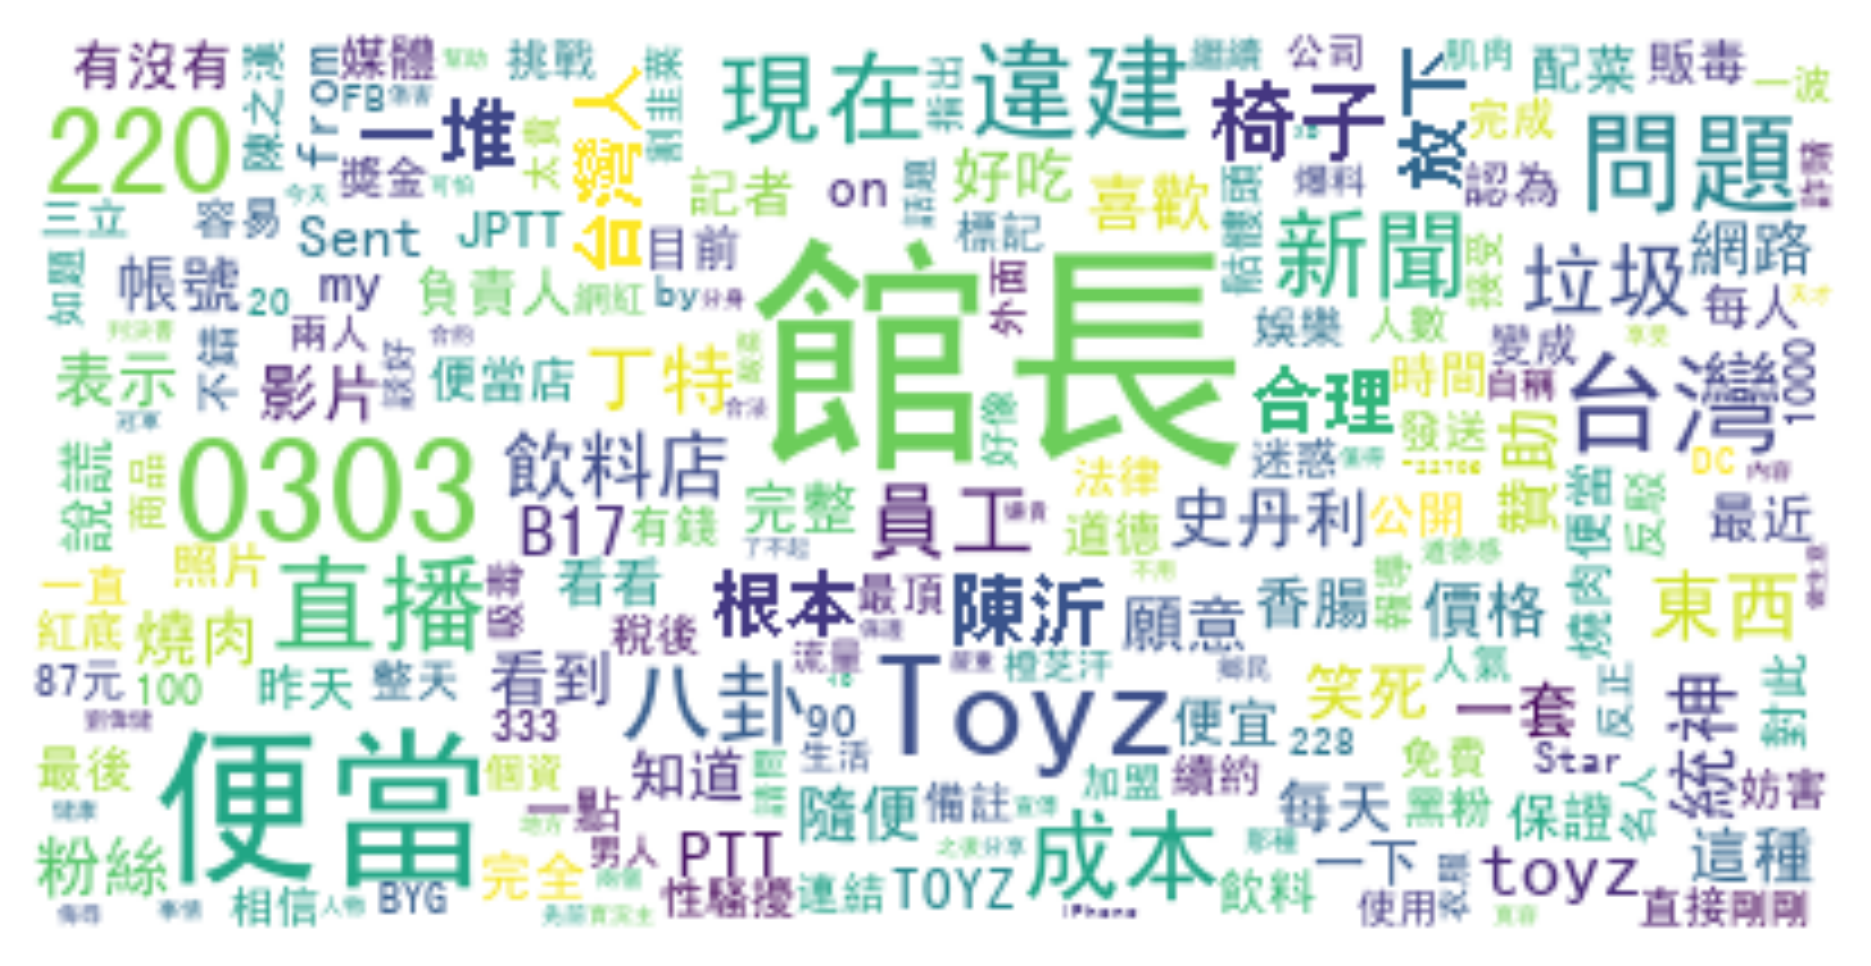

In [104]:
# wordcloud 的 input 是 dictionary
font_path = "./raw_data/SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, background_color="white", font_path=fontPath)
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=300)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

0303是日期，最大字除館長 toyz就是便當、成本、違建。
從文字雲可以推測，當日PPT網友在討論館長與Toyz各自的食品創始店，館長因為賣燒肉便當賣220元，Toyz認為價格相當昂貴，館長則認為Toyz的飲料店存在違建問題，雙方正在發生激烈爭吵。

(-0.5, 399.5, 199.5, -0.5)

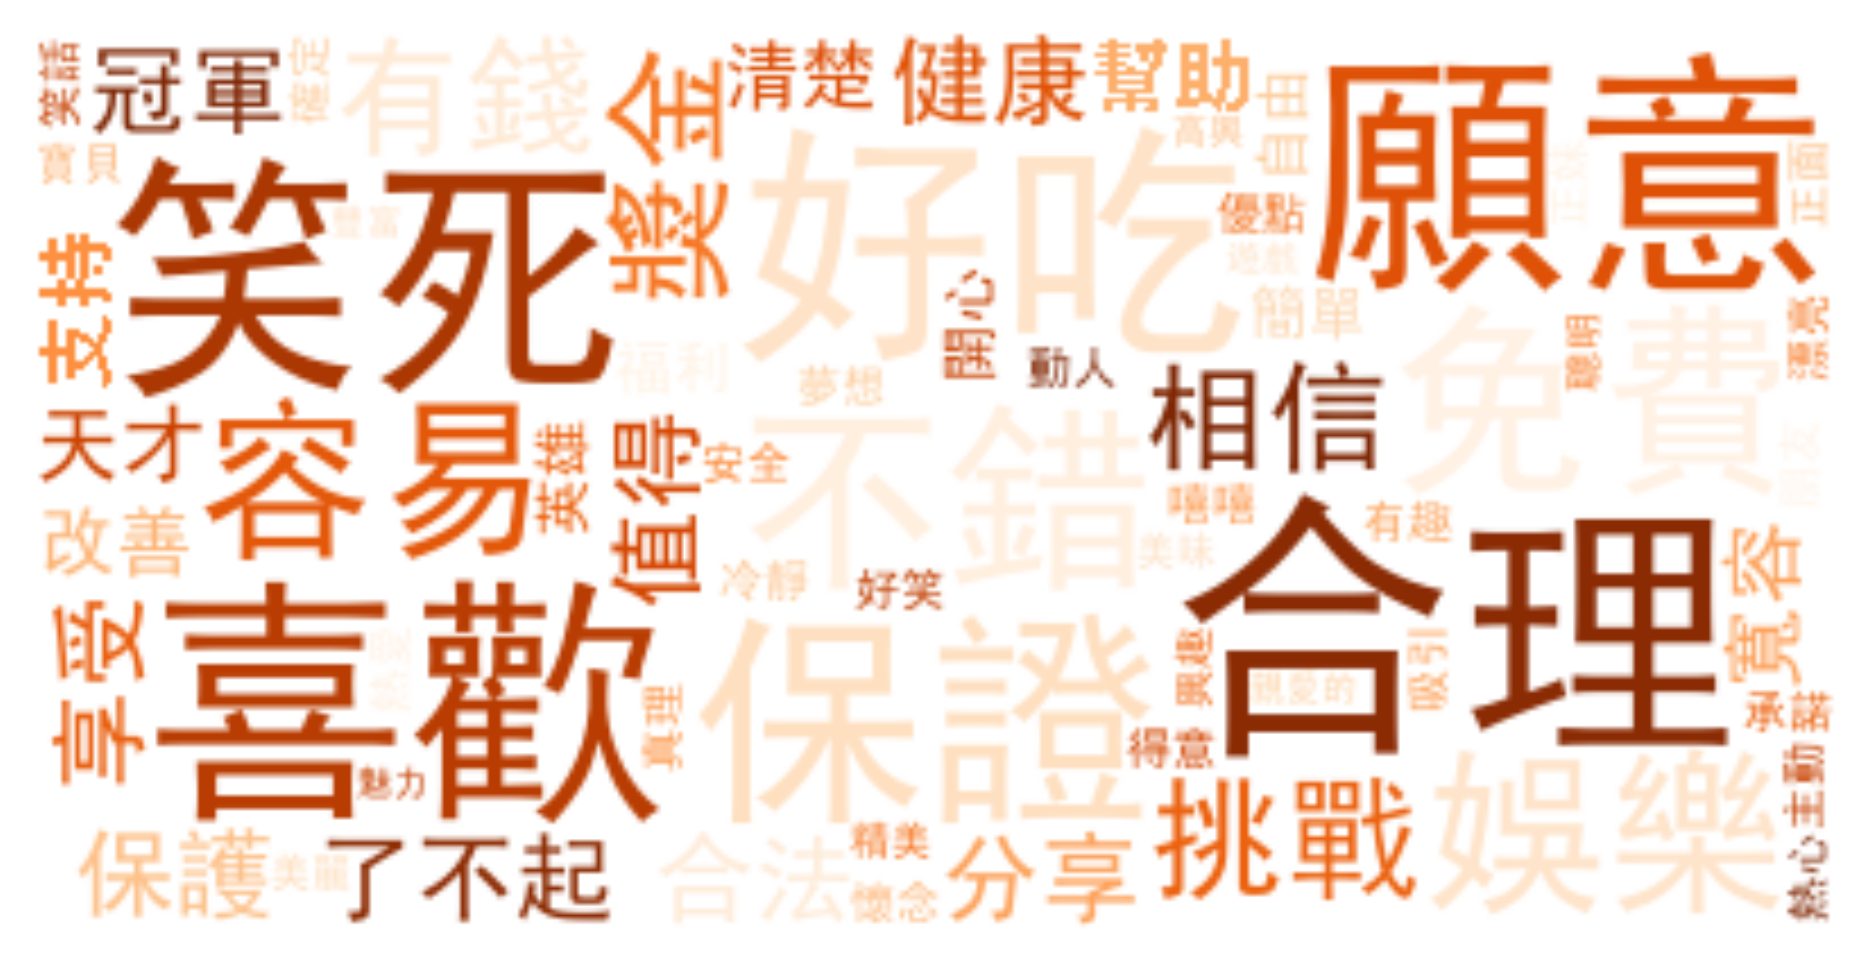

In [105]:
date = "2023-03-03"
mask = (ptt_liwc_df["artDate"] == pd.Timestamp(date)) & (
    ptt_liwc_df["sentiments"] == "positive"
)
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

# wordcloud 的 input 是 dictionary
cloud = WordCloud(max_words=200, background_color="white", font_path=fontPath, colormap="Oranges")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=300)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

有人認為館長的便當賣那麼貴是有道理的的，有人也評論便當好吃，價格合理。

(-0.5, 399.5, 199.5, -0.5)

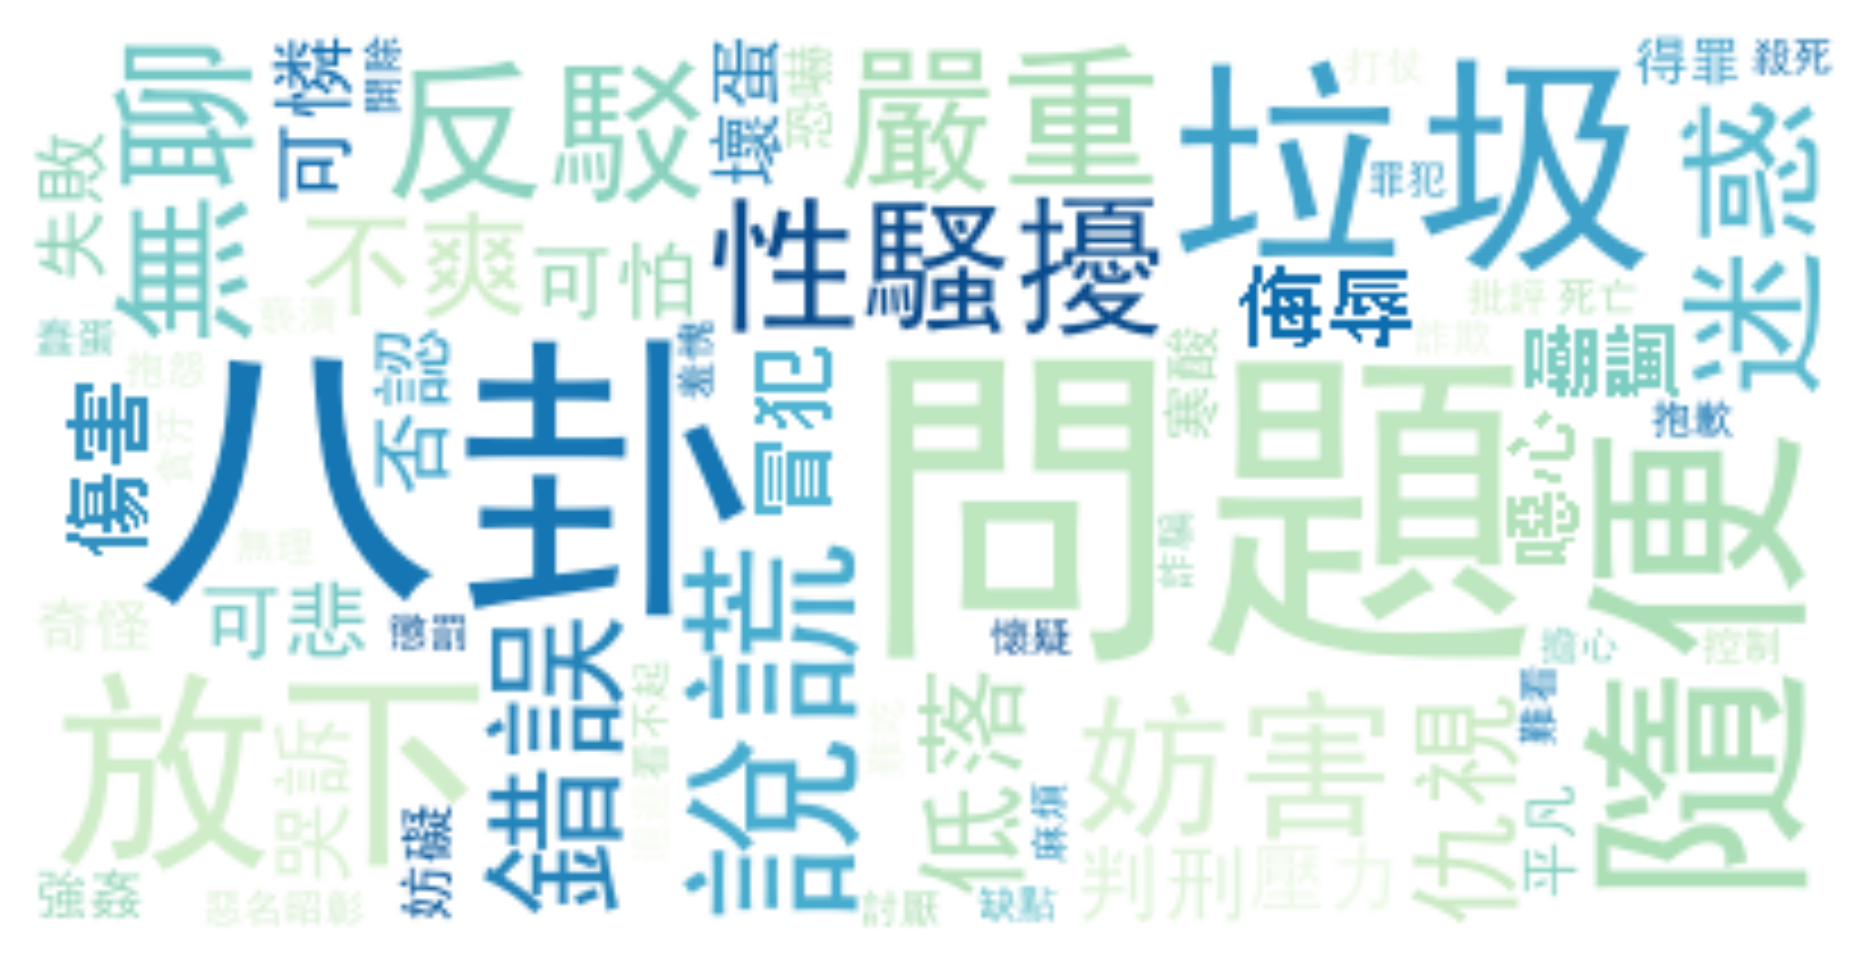

In [106]:
date = "2023-03-03"
mask = (ptt_liwc_df["artDate"] == pd.Timestamp(date)) & (
    ptt_liwc_df["sentiments"] == "negative"
)
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

# wordcloud 的 input 是 dictionary
cloud = WordCloud(max_words=200, background_color="white", font_path=fontPath, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=300)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

而負面字詞多為吵架用詞，其中「八卦」在此處偏正面一些，也能解釋為粉絲們多以看事件八卦為主。

#### 3-6 情緒代表字
從整個文集中計算出正負向情緒字的出現詞頻，並找出情緒的代表字。

In [107]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_count

word sentiments  size
478    問題   negative   518
477    問題     affect   518
267    八卦   negative   467
266    八卦     affect   467
1199   支持     affect   231
...   ...        ...   ...
1235   敏捷   positive     1
1239   敬意     affect     1
1240   敬意   positive     1
1241   敬畏     affect     1
2348   鼻酸        sad     1

[2349 rows x 3 columns]

In [108]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_pos

word sentiments  size
1200   支持   positive   231
755    希望   positive   175
1295   朋友   positive   125
301    利潤   positive   119
493    喜歡   positive   116
...   ...        ...   ...
1147   振作   positive     1
1176   摯友   positive     1
1180   擁抱   positive     1
1235   敏捷   positive     1
1240   敬意   positive     1

[416 rows x 3 columns]

In [109]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
word_of_neg

word sentiments  size
478    問題   negative   518
267    八卦   negative   467
547    垃圾   negative   176
2240   隨便   negative   127
1569   犯罪   negative   117
...   ...        ...   ...
1168   搏鬥   negative     1
1173   摧毀   negative     1
1188   操心   negative     1
1195   擔憂   negative     1
1198   攪亂   negative     1

[544 rows x 3 columns]

In [110]:
word_of_neg.sort_values(
    ["size"], ascending=False
)

word sentiments  size
478    問題   negative   518
267    八卦   negative   467
547    垃圾   negative   176
2240   隨便   negative   127
1569   犯罪   negative   117
...   ...        ...   ...
865    怒斥   negative     1
871    怕生   negative     1
712    寒酸   negative     1
742    小氣   negative     1
1198   攪亂   negative     1

[544 rows x 3 columns]

/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0.5, 1.0, '負向情緒總數')

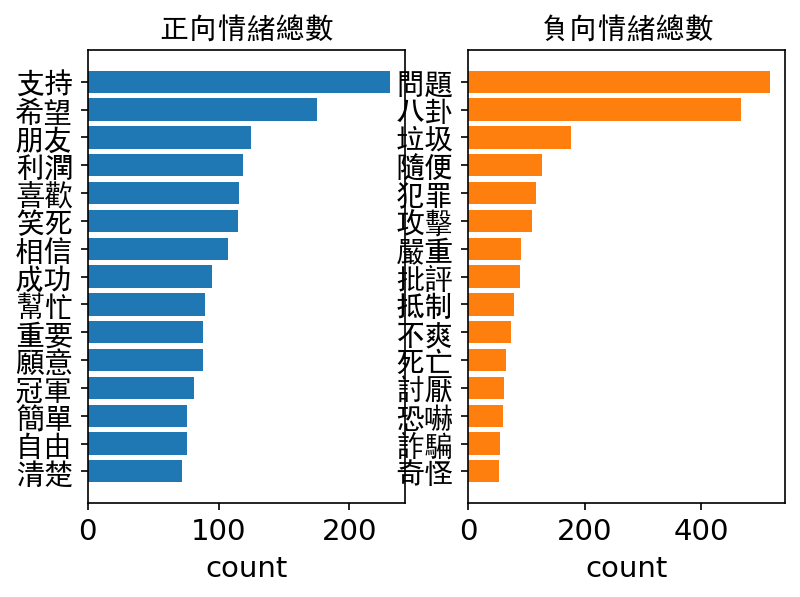

In [111]:
pos = word_of_pos.sort_values(
    ["size"], ascending=True
).iloc[-15:,:]
neg = word_of_neg.sort_values(
    ["size"], ascending=True
).iloc[-15:,:]

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

#### 3-7. 每日情緒分數趨勢
如同先前整理出「八卦」，雖然粉絲看得愉快但不屬於正向陽光的詞彙，所以不僅是考慮正負面(positive/negative)，再扣除其他偏負面的字詞(anger/anx/sad等)，我們可以從每日情緒分數趨勢圖看出來這整件事情的經過，並沒有在網路上造成很好的正面回應，大多是屬於負面的文章。

In [112]:
sentiment_count

artDate sentiments  size     ratio
0    2022-12-01     affect   221  0.045661
1    2022-12-01      anger    47  0.009711
2    2022-12-01        anx    16  0.003306
3    2022-12-01   negative   115  0.023760
4    2022-12-01   positive    91  0.018802
..          ...        ...   ...       ...
854  2023-04-17        sad     6  0.002254
850  2023-04-17      anger    33  0.012397
849  2023-04-17     affect   161  0.060481
851  2023-04-17        anx     1  0.000376
855  2023-04-17        NaN  2307  0.866642

[856 rows x 4 columns]

In [113]:
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value.head()

artDate  affect  anger  anx  negative  positive  sad
0  2022-12-01     221     47   16       115        91   21
1  2022-12-02     784    135   45       407       299   57
2  2022-12-03     197     40   18       116        68   18
3  2022-12-04     100     20    8        53        39    3
4  2022-12-05     322     47   16       165       132   15

In [114]:
# sentiment 計算方式: positive - anger - anx - negative - sad
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["anger"]
    - ptt_sentiment_value["anx"]
    - ptt_sentiment_value["negative"]
    - ptt_sentiment_value["sad"]
)
ptt_sentiment_value.head()

artDate  affect  anger  anx  negative  positive  sad  sentiment_value
0  2022-12-01     221     47   16       115        91   21             -108
1  2022-12-02     784    135   45       407       299   57             -345
2  2022-12-03     197     40   18       116        68   18             -124
3  2022-12-04     100     20    8        53        39    3              -45
4  2022-12-05     322     47   16       165       132   15             -111

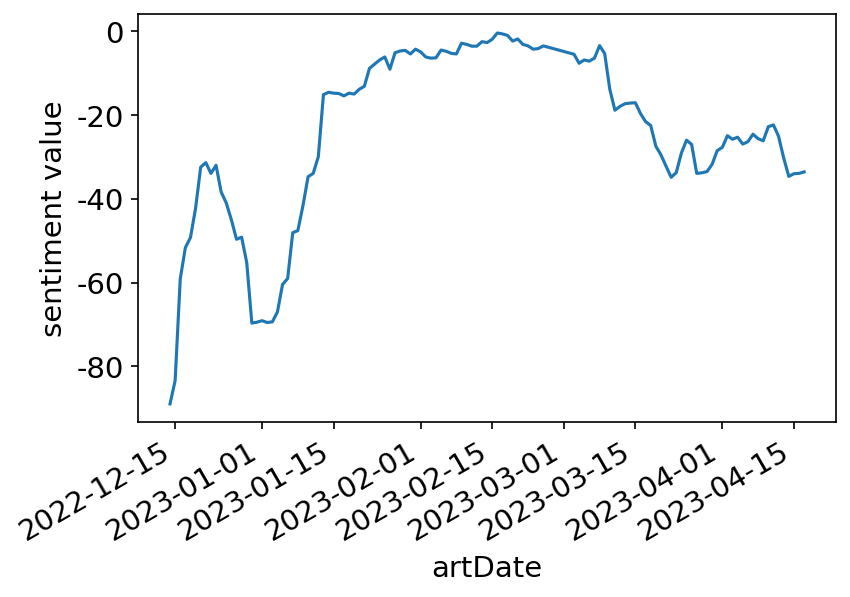

In [115]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()

### 4. 利用SnowNLP進行情緒分析

In [116]:
from snownlp import SnowNLP

使用先前NER得到的「陳之漢」相關文章，看看陳之漢相關文章的情緒表現。<br>
首先將句子和日期合併，方便之後做分析。

In [155]:
sentence_table = pd.read_csv("raw_data/sentence_table_toyz.csv") #匯資料

sentiment_date = pd.merge(sentence_table,strong_selected[['system_id','artDate','dataSource']],on='system_id',how='left').dropna()
sentiment_date.head()

system_id sentence              artDate dataSource
33          3     媒體來源  2022-12-01 08:51:54        ptt
34          3       中時  2022-12-01 08:51:54        ptt
35          3     記者署名  2022-12-01 08:51:54        ptt
36          3      黃朝郁  2022-12-01 08:51:54        ptt
37          3   完整新聞標題  2022-12-01 08:51:54        ptt

#### 4-1. 情緒盒狀圖
我們可以從這張boxplot得知有關陳之漢的文章大多都是屬於負面的文章，情緒分數也較低。

In [156]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head()

system_id sentence              artDate dataSource  sentimentValue
33          3     媒體來源  2022-12-01 08:51:54        ptt        0.219627
34          3       中時  2022-12-01 08:51:54        ptt        0.478545
35          3     記者署名  2022-12-01 08:51:54        ptt        0.729795
36          3      黃朝郁  2022-12-01 08:51:54        ptt        0.473767
37          3   完整新聞標題  2022-12-01 08:51:54        ptt        0.072201

In [157]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe()

count    6.397000e+03
mean     3.577743e-01
std      3.093730e-01
min      2.203789e-08
25%      6.858410e-02
50%      2.932213e-01
75%      5.625000e-01
max      9.999940e-01
Name: sentimentValue, dtype: float64

<AxesSubplot:>

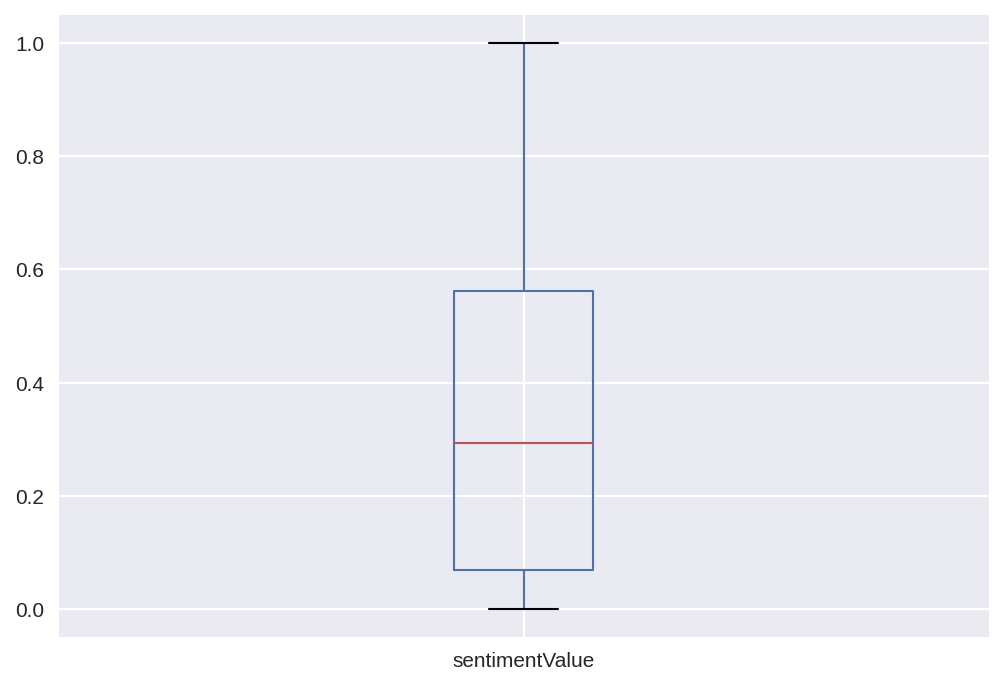

In [158]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

#### 4-2. 每日情緒平均  
將每週的情緒分數取平均，並轉換時間格式為年月。  
與先前使用字典做情緒分析不同，使用SnowNLP的值域為0~1，可以佐證先前結果: 對於此議題PPT情緒是較為負面的。  

In [159]:
sent_date = sentiment_date.copy()
sent_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.to_period('W')

sentiment_count = sent_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count.head()

artDate  sentimentValue
0  2022-11-28/2022-12-04        0.360955
1  2022-12-05/2022-12-11        0.369704
2  2022-12-12/2022-12-18        0.444615
3  2022-12-19/2022-12-25        0.297099
4  2022-12-26/2023-01-01        0.383871

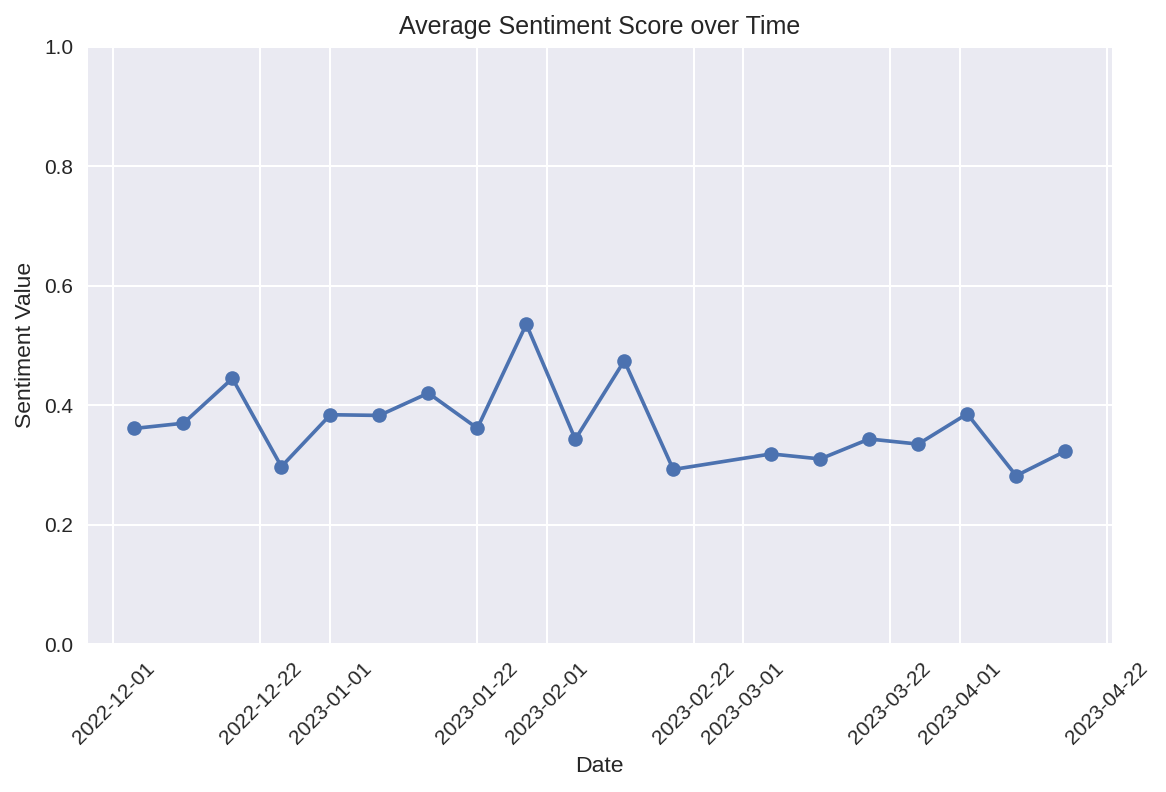

In [160]:
# 平均情緒分數時間趨勢
import matplotlib.dates as mdates

plt.style.use('seaborn')
fig, ax = plt.subplots()

# Plot data
months = sentiment_count['artDate']
y = sentiment_count['sentimentValue']
ax.plot_date(months, y, linestyle='solid')

# Set x-axis rotation
ax.tick_params(axis='x', rotation=45)  # Specify rotation angle (in degrees)

# Format x-axis date labels
date_fmt = mdates.DateFormatter('%Y-%m-%d')  # Choose desired date format
ax.xaxis.set_major_formatter(date_fmt)

# Set y-axis limits
ax.set_ylim(0, 1)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Sentiment Value')
ax.set_title('Average Sentiment Score over Time')

plt.tight_layout()
plt.show()

從上圖中發現大部分天數的情緒值都在0.4左右，偏向負面。

----

使用NER得到的「Toyz」，做一樣的情緒分析

In [161]:
sentence_table = pd.read_csv("raw_data/sentence_table_toyz.csv") #匯資料
# 合併toyz_selected
sentiment_date = pd.merge(sentence_table,toyz_selected[['system_id','artDate','dataSource']],on='system_id',how='left').dropna()

In [162]:
toyz_selected.head()

system_id                                             artUrl  \
188        189  https://www.ptt.cc/bbs/Gossiping/M.1670045891....   
352        353  https://www.ptt.cc/bbs/Gossiping/M.1670486896....   
396        397  https://www.ptt.cc/bbs/Gossiping/M.1670686027....   
413        414  https://www.ptt.cc/bbs/Gossiping/M.1670833500....   
422        423  https://www.ptt.cc/bbs/Gossiping/M.1670909741....   

                     artTitle              artDate    artPoster artCatagory  \
188           [問卦]館長是不是死亡直播啊？  2022-12-03 13:38:09      tyo5151   Gossiping   
352      [問卦]Toyz會邀請烏鴉上他的節目嗎？  2022-12-08 16:08:14     h2030625   Gossiping   
396        [問卦]如果有Toyz與統神兄弟影集  2022-12-10 23:27:05  AngelsDemon   Gossiping   
413        [問卦]還有誰是「物極必反」的下場？  2022-12-12 16:24:57     DavidJam   Gossiping   
422  [問卦]如果Toyz賣刑事訴訟體驗筆記會有爭議嗎  2022-12-13 13:35:39       a04775   Gossiping   

                                            artContent  \
188  2018.4  Tao直播訪談\n2018.7  自強隧道飆車競速 間接導致2死3傷的車禍意...   
352  烏鴉現在被逮捕了之後也可能要坐牢\n\nToyz不知道會不會邀請烏鴉\n\n上他的節目像Gi...   
396  各位肥宅安安\n\n剛剛跟朋友聊天聊到網飛\n\n如果網飛出一個Toyz跟統神兄弟的影集\n...   
413  大家好\n\n有句話叫「囂張沒有落魄的久」\n\n像是已經被關進去\n\n因為製作換臉A片的...   
422  如題\n\nToyz劉偉健，是知名實況主\n\n因為販賣二級毒品大麻遭逮捕、羈押，台中地院依...   

                                            artComment             e_ip  \
188  [{"cmtStatus": "→", "cmtPoster": "johnwu", "cm...  223.136.239.195   
352  [{"cmtStatus": "噓", "cmtPoster": "Usayhiisayha...    111.82.128.56   
396  [{"cmtStatus": "噓", "cmtPoster": "deepdish", "...  210.208.106.157   
413  [{"cmtStatus": "推", "cmtPoster": "a0986188522"...  114.136.252.112   
422  [{"cmtStatus": "→", "cmtPoster": "su4vu6", "cm...     61.228.26.50   

            insertedDate dataSource  
188  2022-12-04 01:28:22        ptt  
352  2022-12-09 01:32:43        ptt  
396  2022-12-11 01:35:30        ptt  
413  2022-12-13 01:29:33        ptt  
422  2022-12-14 01:29:19        ptt

情緒盒狀圖 <br>


In [163]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head()

system_id             sentence              artDate dataSource  \
3735        189                 直播訪談  2022-12-03 13:38:09        ptt   
3736        189  自強隧道飆車競速間接導致死傷的車禍意外  2022-12-03 13:38:09        ptt   
3737        189              謝龍介直播訪談  2022-12-03 13:38:09        ptt   
3738        189       及立委補選及不分區立委均落敗  2022-12-03 13:38:09        ptt   
3739        189              韓國瑜直播訪談  2022-12-03 13:38:09        ptt   

      sentimentValue  
3735        0.525248  
3736        0.464423  
3737        0.839942  
3738        0.570675  
3739        0.472783

In [164]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe()

count    6.365000e+03
mean     3.440610e-01
std      2.919817e-01
min      8.905610e-11
25%      7.249288e-02
50%      2.732191e-01
75%      5.379672e-01
max      9.999905e-01
Name: sentimentValue, dtype: float64

<AxesSubplot:>

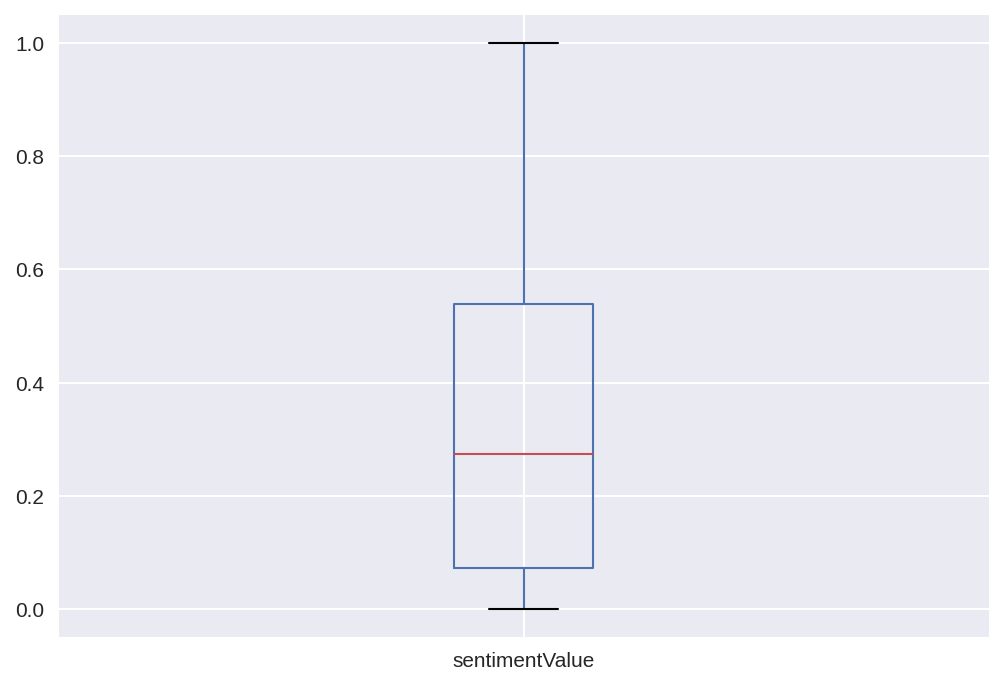

In [165]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

 每日情緒平均  <br>
將每週的情緒分數取平均，並轉換時間格式為年月。  
與先前使用字典做情緒分析不同，使用SnowNLP的值域為0~1，可以佐證先前結果: 對於此議題PPT情緒是較為負面的。  

In [166]:
sent_date = sentiment_date.copy()
sent_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.to_period('W')

sentiment_count = sent_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count.head()

artDate  sentimentValue
0  2022-11-28/2022-12-04        0.546215
1  2022-12-05/2022-12-11        0.331921
2  2022-12-12/2022-12-18        0.431608
3  2022-12-19/2022-12-25        0.327892
4  2022-12-26/2023-01-01        0.354258

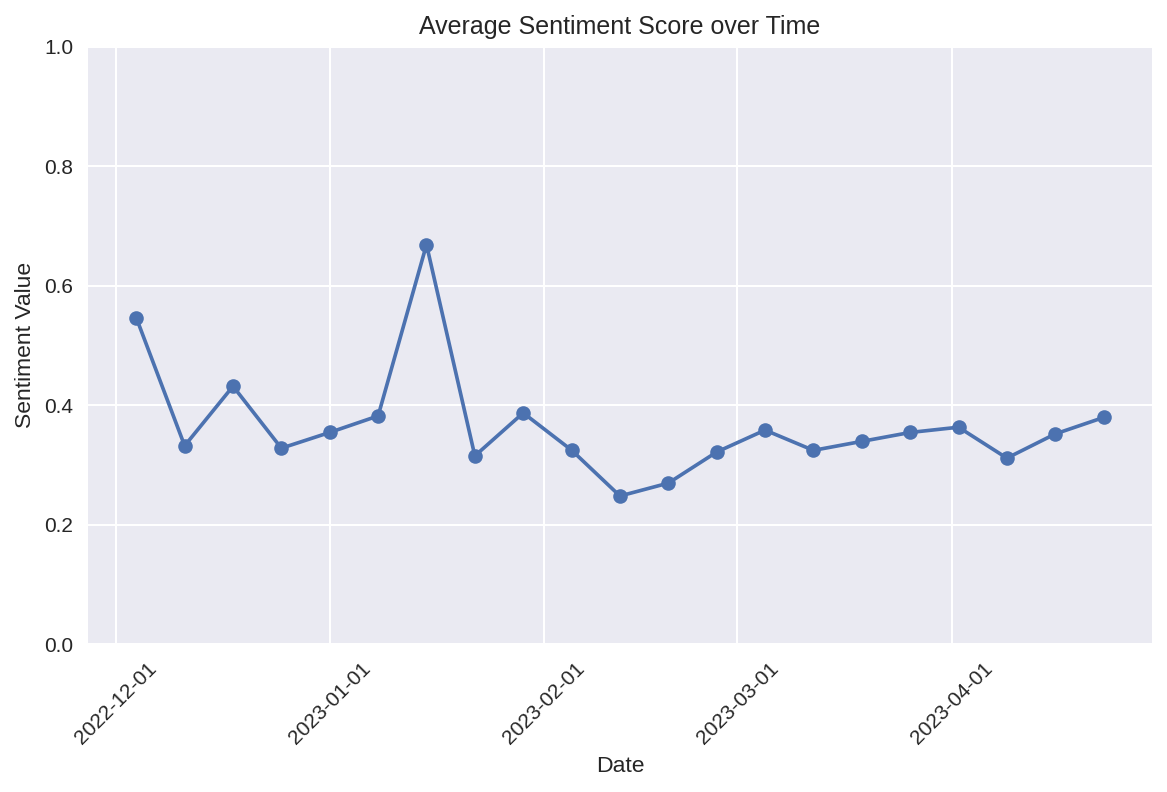

In [167]:
# 平均情緒分數時間趨勢
import matplotlib.dates as mdates

plt.style.use('seaborn')
fig, ax = plt.subplots()

# Plot data
months = sentiment_count['artDate']
y = sentiment_count['sentimentValue']
ax.plot_date(months, y, linestyle='solid')

# Set x-axis rotation
ax.tick_params(axis='x', rotation=45)  # Specify rotation angle (in degrees)

# Format x-axis date labels
date_fmt = mdates.DateFormatter('%Y-%m-%d')  # Choose desired date format
ax.xaxis.set_major_formatter(date_fmt)

# Set y-axis limits
ax.set_ylim(0, 1)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Sentiment Value')
ax.set_title('Average Sentiment Score over Time')

plt.tight_layout()
plt.show()

### 5. TF-IDF
TF-IDF 是一種統計方法，可用來評估單詞對於文件的集合的重要程度  
- **TF** (Term Frequency)：某一個詞彙在某一個文件中所出現的頻率  
    - TF = 詞彙在該文件中出現次數 / 該文件中詞彙總數  
- **IDF** (Inverse Document Frequent)：為文件數除以某特定詞彙有被多少文件所提及的數量取log  
    - IDF = log( 總文件數量 / 包含該詞彙的文件數量 ) 

#### 5-1. 計算每篇文章的 總詞彙數 與 各個詞彙數

In [123]:
# 每篇文章的總詞彙數
total_words = noStop_df.groupby(['artUrl'],as_index=False).size()
total_words.rename(columns={'size': 'total'}, inplace=True)
total_words

artUrl  total
0     https://www.ptt.cc/bbs/Gossiping/M.1669824097....     56
1     https://www.ptt.cc/bbs/Gossiping/M.1669825911....     49
2     https://www.ptt.cc/bbs/Gossiping/M.1669855917....    241
3     https://www.ptt.cc/bbs/Gossiping/M.1669859150....     88
4     https://www.ptt.cc/bbs/Gossiping/M.1669871385....    113
...                                                 ...    ...
3146  https://www.ptt.cc/bbs/Gossiping/M.1681733034....     26
3147  https://www.ptt.cc/bbs/Gossiping/M.1681734452....     27
3148  https://www.ptt.cc/bbs/Gossiping/M.1681737207....     25
3149  https://www.ptt.cc/bbs/Gossiping/M.1681740134....     43
3150  https://www.ptt.cc/bbs/Gossiping/M.1681740749....     40

[3151 rows x 2 columns]

In [124]:
# 計算各詞彙在各文章中出現的次數
word_count = noStop_df.groupby(['artUrl','word'],as_index=False).size()
word_count.rename(columns={'size': 'count'}, inplace=True)
word_count

artUrl  word  count
0       https://www.ptt.cc/bbs/Gossiping/M.1669824097....  2020      1
1       https://www.ptt.cc/bbs/Gossiping/M.1669824097....   623      1
2       https://www.ptt.cc/bbs/Gossiping/M.1669824097....    一件      1
3       https://www.ptt.cc/bbs/Gossiping/M.1669824097....    一步      1
4       https://www.ptt.cc/bbs/Gossiping/M.1669824097....    一遍      1
...                                                   ...   ...    ...
149255  https://www.ptt.cc/bbs/Gossiping/M.1681740749....    詐賭      1
149256  https://www.ptt.cc/bbs/Gossiping/M.1681740749....    販毒      1
149257  https://www.ptt.cc/bbs/Gossiping/M.1681740749....    那種      1
149258  https://www.ptt.cc/bbs/Gossiping/M.1681740749....    關我      1
149259  https://www.ptt.cc/bbs/Gossiping/M.1681740749....    館長      1

[149260 rows x 3 columns]

In [125]:
# 合併需要的資料欄位
food_words = word_count.merge(total_words,on = 'artUrl',how = 'left')
food_words

artUrl  word  count  total
0       https://www.ptt.cc/bbs/Gossiping/M.1669824097....  2020      1     56
1       https://www.ptt.cc/bbs/Gossiping/M.1669824097....   623      1     56
2       https://www.ptt.cc/bbs/Gossiping/M.1669824097....    一件      1     56
3       https://www.ptt.cc/bbs/Gossiping/M.1669824097....    一步      1     56
4       https://www.ptt.cc/bbs/Gossiping/M.1669824097....    一遍      1     56
...                                                   ...   ...    ...    ...
149255  https://www.ptt.cc/bbs/Gossiping/M.1681740749....    詐賭      1     40
149256  https://www.ptt.cc/bbs/Gossiping/M.1681740749....    販毒      1     40
149257  https://www.ptt.cc/bbs/Gossiping/M.1681740749....    那種      1     40
149258  https://www.ptt.cc/bbs/Gossiping/M.1681740749....    關我      1     40
149259  https://www.ptt.cc/bbs/Gossiping/M.1681740749....    館長      1     40

[149260 rows x 4 columns]

#### 5-2. 計算 tf-idf 值
- 以每篇文章爲單位，計算每個詞彙的 tf-idf 值  
    - tf-idf = tf * idf

In [126]:
# 計算tf
food_words_tf_idf = food_words.assign(tf = food_words.iloc[:,2]/food_words.iloc[:,3])
food_words_tf_idf.head()

artUrl  word  count  total  \
0  https://www.ptt.cc/bbs/Gossiping/M.1669824097....  2020      1     56   
1  https://www.ptt.cc/bbs/Gossiping/M.1669824097....   623      1     56   
2  https://www.ptt.cc/bbs/Gossiping/M.1669824097....    一件      1     56   
3  https://www.ptt.cc/bbs/Gossiping/M.1669824097....    一步      1     56   
4  https://www.ptt.cc/bbs/Gossiping/M.1669824097....    一遍      1     56   

         tf  
0  0.017857  
1  0.017857  
2  0.017857  
3  0.017857  
4  0.017857

In [127]:
# 計算每個詞彙出現在幾篇文章中
idf_df = food_words.groupby(['word'],as_index=False).size()
food_words_tf_idf = food_words_tf_idf.merge(idf_df,on = 'word',how = 'left')
food_words_tf_idf.head()

artUrl  word  count  total  \
0  https://www.ptt.cc/bbs/Gossiping/M.1669824097....  2020      1     56   
1  https://www.ptt.cc/bbs/Gossiping/M.1669824097....   623      1     56   
2  https://www.ptt.cc/bbs/Gossiping/M.1669824097....    一件      1     56   
3  https://www.ptt.cc/bbs/Gossiping/M.1669824097....    一步      1     56   
4  https://www.ptt.cc/bbs/Gossiping/M.1669824097....    一遍      1     56   

         tf  size  
0  0.017857    27  
1  0.017857    10  
2  0.017857    26  
3  0.017857    11  
4  0.017857     6

In [128]:
# 計算idf
food_words_tf_idf = food_words_tf_idf.assign(idf = food_words_tf_idf.iloc[:,5]
                                               .apply(lambda x: math.log((len(total_words)/x),10)))

food_words_tf_idf = food_words_tf_idf.drop(labels=['size'],axis=1)
food_words_tf_idf.head()

artUrl  word  count  total  \
0  https://www.ptt.cc/bbs/Gossiping/M.1669824097....  2020      1     56   
1  https://www.ptt.cc/bbs/Gossiping/M.1669824097....   623      1     56   
2  https://www.ptt.cc/bbs/Gossiping/M.1669824097....    一件      1     56   
3  https://www.ptt.cc/bbs/Gossiping/M.1669824097....    一步      1     56   
4  https://www.ptt.cc/bbs/Gossiping/M.1669824097....    一遍      1     56   

         tf       idf  
0  0.017857  2.067085  
1  0.017857  2.498448  
2  0.017857  2.083475  
3  0.017857  2.457056  
4  0.017857  2.720297

In [129]:
# 計算tf*idf
food_words_tf_idf = food_words_tf_idf.assign(tf_idf = food_words_tf_idf.iloc[:,4] * food_words_tf_idf.iloc[:,5])
food_words_tf_idf.head()

artUrl  word  count  total  \
0  https://www.ptt.cc/bbs/Gossiping/M.1669824097....  2020      1     56   
1  https://www.ptt.cc/bbs/Gossiping/M.1669824097....   623      1     56   
2  https://www.ptt.cc/bbs/Gossiping/M.1669824097....    一件      1     56   
3  https://www.ptt.cc/bbs/Gossiping/M.1669824097....    一步      1     56   
4  https://www.ptt.cc/bbs/Gossiping/M.1669824097....    一遍      1     56   

         tf       idf    tf_idf  
0  0.017857  2.067085  0.036912  
1  0.017857  2.498448  0.044615  
2  0.017857  2.083475  0.037205  
3  0.017857  2.457056  0.043876  
4  0.017857  2.720297  0.048577

#### 5-3. 檢視結果

In [130]:
# 選出每篇文章，tf-idf值最大的前五個詞
group = food_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(5, "tf_idf"))

In [131]:
group.loc[:,["word","tf_idf"]][0:15]

word  \
artUrl                                                                                                     
https://www.ptt.cc/bbs/Gossiping/M.1669824097.A... 24                                                 朝廷   
                                                   28                                                 當今   
                                                   40                                                 阿館   
                                                   21                                                 搞過   
                                                   30                                                 祭旗   
https://www.ptt.cc/bbs/Gossiping/M.1669825911.A... 63                                                 地帶   
                                                   74                                                 灰色   
                                                   49   httpsiimgurcomCD5DvIdjpghttpsiimgurcomeOV5Lftjpg   
                                                   50                           httpsiimgurcomh0AUGwJjpg   
                                                   51       httpswwwpttccbbsGossipingM1644324378A796html   
https://www.ptt.cc/bbs/Gossiping/M.1669855917.A... 246                                               陳明文   
                                                   151                                                政府   
                                                   170                                               民進黨   
                                                   100                                               上凱道   
                                                   216                                                記錄   

                                                          tf_idf  
artUrl                                                            
https://www.ptt.cc/bbs/Gossiping/M.1669824097.A... 24   0.249889  
                                                   28   0.161857  
                                                   40   0.115565  
                                                   21   0.062472  
                                                   30   0.062472  
https://www.ptt.cc/bbs/Gossiping/M.1669825911.A... 63   0.142794  
                                                   74   0.142794  
                                                   49   0.071397  
                                                   50   0.071397  
                                                   51   0.071397  
https://www.ptt.cc/bbs/Gossiping/M.1669855917.A... 246  0.056411  
                                                   151  0.043992  
                                                   170  0.035099  
                                                   100  0.032862  
                                                   216  0.027354

##### 計算整個文集中較常 tf-idf 值高的字

In [132]:
# 從每篇文章挑選出tf-idf最大的前十個詞
(food_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(10, "tf_idf")).reset_index(drop=True)
# 計算每個詞被選中的次數
.groupby(['word'],as_index=False).size()
).sort_values('size', ascending=False).head(10) # 排序看前十名

word  size
874    Toyz    94
1771   toyz    88
3448     便當    85
10936   民進黨    79
13341    統神    77
10515    椅子    72
17637    黑道    71
5166    史丹利    68
17369    館長    63
16871    阿館    49

如上，整理出整起事件最重要的關鍵詞包括主角: 館長、Toyz，還有在吵架中被牽扯進的議題如: 便當、民進黨、黑道，可以推測事件過程演進，到後來重點已經不是最初的契約糾紛，已經演變到其他角度。

### 6. 建立Ngram預測模型
N-gram 指文本中連續出現的n個語詞。 透過N-gram我們可以找出有哪些詞彙較常一起出現，檢查是否需要加入自定義字典中。  
N-gram範例：

#### 6-1. Bigram

In [98]:
# 設定 bigram 斷詞 function
def bigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopwords and len(w)>1]
    seg_list = ngrams(seg_list, 2) # 2來設定單詞數量
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [99]:
food_bigram = sent_df.copy()

food_bigram["word"] = food_bigram.sentence.apply(bigram_getToken)
food_bigram = food_bigram.explode('word')
food_bigram.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/Gossiping/M.1669824097....   
0          1  https://www.ptt.cc/bbs/Gossiping/M.1669824097....   
0          1  https://www.ptt.cc/bbs/Gossiping/M.1669824097....   

                   artTitle              artDate    artPoster artCatagory  \
0  Re:[問卦]館長向全台最大黑道宣戰都不怕出事？  2022-12-01 00:01:35  thegreatlcx   Gossiping   
0  Re:[問卦]館長向全台最大黑道宣戰都不怕出事？  2022-12-01 00:01:35  thegreatlcx   Gossiping   
0  Re:[問卦]館長向全台最大黑道宣戰都不怕出事？  2022-12-01 00:01:35  thegreatlcx   Gossiping   

                               sentence  \
0  我是想一件事很不明白照阿館所說對阿館開槍的背後真的是當今朝廷有點不合理呀   
0  我是想一件事很不明白照阿館所說對阿館開槍的背後真的是當今朝廷有點不合理呀   
0  我是想一件事很不明白照阿館所說對阿館開槍的背後真的是當今朝廷有點不合理呀   

                                          artComment             e_ip  \
0  [{"cmtStatus": "推", "cmtPoster": "shvzrrsy", "...  123.192.152.105   
0  [{"cmtStatus": "推", "cmtPoster": "shvzrrsy", "...  123.192.152.105   
0  [{"cmtStatus": "推", "cmtPoster": "shvzrrsy", "...  123.192.152.105   

          insertedDate dataSource  \
0  2022-12-02 01:27:18        ptt   
0  2022-12-02 01:27:18        ptt   
0  2022-12-02 01:27:18        ptt   

                                                       word  
0  我是想一件事很不明白照阿館所說對阿館開槍的背後真的是當今朝廷有點不合理呀。因為當初年的時候芒...  明白 阿館  
0  我是想一件事很不明白照阿館所說對阿館開槍的背後真的是當今朝廷有點不合理呀。因為當初年的時候芒...  阿館 阿館  
0  我是想一件事很不明白照阿館所說對阿館開槍的背後真的是當今朝廷有點不合理呀。因為當初年的時候芒...  阿館 開槍

##### 統計最常出現的bigram組合

In [100]:
# 計算每個組合出現的次數
food_bigram_count = food_bigram.groupby(["word"],as_index=False).size()
food_bigram_count.head()

word  size
0   00 中午     1
1   00 便當     1
2   00 出生     1
3  00 台灣人     1
4   00 還好     1

In [101]:
# 清除包含英文或數字的bigram組合
fb_filter = list(food_bigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
food_bigram_count[fb_filter].sort_values(by=['size'], ascending=False).head(10)

word  size
102284   館長 直播   311
103025  館長 陳之漢   215
83937    記者 署名   202
53279    新聞 標題   202
53219    新聞 內文   201
89616    轉載 媒體   184
100985   館長 便當   159
53322    新聞 轉載   132
52901    文章 刪除   113
53267    新聞 文章   112

#### 6-2. Trigram

In [102]:
# 設定 trigram 斷詞 function
def trigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopwords and len(w)>1]
    seg_list = ngrams(seg_list, 3)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [103]:
food_trigram = sent_df.copy()

food_trigram["word"] = food_trigram.sentence.apply(trigram_getToken)
food_trigram = food_trigram.explode('word')
food_trigram.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/Gossiping/M.1669824097....   
0          1  https://www.ptt.cc/bbs/Gossiping/M.1669824097....   
0          1  https://www.ptt.cc/bbs/Gossiping/M.1669824097....   

                   artTitle              artDate    artPoster artCatagory  \
0  Re:[問卦]館長向全台最大黑道宣戰都不怕出事？  2022-12-01 00:01:35  thegreatlcx   Gossiping   
0  Re:[問卦]館長向全台最大黑道宣戰都不怕出事？  2022-12-01 00:01:35  thegreatlcx   Gossiping   
0  Re:[問卦]館長向全台最大黑道宣戰都不怕出事？  2022-12-01 00:01:35  thegreatlcx   Gossiping   

                               sentence  \
0  我是想一件事很不明白照阿館所說對阿館開槍的背後真的是當今朝廷有點不合理呀   
0  我是想一件事很不明白照阿館所說對阿館開槍的背後真的是當今朝廷有點不合理呀   
0  我是想一件事很不明白照阿館所說對阿館開槍的背後真的是當今朝廷有點不合理呀   

                                          artComment             e_ip  \
0  [{"cmtStatus": "推", "cmtPoster": "shvzrrsy", "...  123.192.152.105   
0  [{"cmtStatus": "推", "cmtPoster": "shvzrrsy", "...  123.192.152.105   
0  [{"cmtStatus": "推", "cmtPoster": "shvzrrsy", "...  123.192.152.105   

          insertedDate dataSource  \
0  2022-12-02 01:27:18        ptt   
0  2022-12-02 01:27:18        ptt   
0  2022-12-02 01:27:18        ptt   

                                                          word  
0  我是想一件事很不明白照阿館所說對阿館開槍的背後真的是當今朝廷有點不合理呀。因為當初年的時候芒...  明白 阿館 阿館  
0  我是想一件事很不明白照阿館所說對阿館開槍的背後真的是當今朝廷有點不合理呀。因為當初年的時候芒...  阿館 阿館 開槍  
0  我是想一件事很不明白照阿館所說對阿館開槍的背後真的是當今朝廷有點不合理呀。因為當初年的時候芒...  阿館 開槍 背後

##### 統計最常出現的trigram組合

In [104]:
# 計算每個組合出現的次數
food_trigram_count = food_trigram.groupby(["word"],as_index=False).size()
# 清除包含英文或數字的trigram組合
fb_filter = list(food_trigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
food_trigram_count[fb_filter].sort_values(by=['size'], ascending=False).head(10)

word  size
44503   新聞 轉載 媒體   132
71221   請放 違者 新聞   112
44362   新聞 文章 刪除   112
76731   違者 新聞 文章   112
63477  網紅 館長 陳之漢    81
44453   新聞 標題 館長    55
44509   新聞 需放 媒體    52
81857   需放 媒體 原始    52
47224  未滿 繁體 中文字    42
63995  繁體 中文字 水桶    42

#### 6-3. 字詞預測

In [108]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopwords and len(w)>1] # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [109]:
sent_dfdata3 = sent_df.copy()
sen_tokens = sent_df.sentence.apply(getToken).tolist()

In [110]:
def ngram(documents, N=2):
    ngram_prediction = dict()
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        # 加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # 計算分母
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction

In [111]:
jieba.set_dictionary('./dict/dict.txt')
# Bigram預測模型為例
bi_prediction = ngram(sen_tokens, N=2)

**預測下一個出現的詞**

In [112]:
text = '館長'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: </s>, probability: 0.112
next word: 直播, probability: 0.0474
next word: 陳之漢, probability: 0.0327
next word: 便當, probability: 0.0242
next word: toyz, probability: 0.00838


In [113]:
text = 'Toyz'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: </s>, probability: 0.0963
next word: 直播, probability: 0.0568
next word: 劉偉健, probability: 0.0434
next word: 館長, probability: 0.0395
next word: 飲料店, probability: 0.0241


### 7. Bigram視覺化

In [114]:
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist()
def bigram_getToken_dict(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopwords and len(w)>1]
    bigramfdist.update(ngrams(seg_list, 2))
    seg_list2 = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [115]:
food_bigram2 = sent_df.copy()
food_bigram2["word"] = food_bigram2.sentence.apply(bigram_getToken_dict)

Building prefix dict from /home/ywwang/1112_socialMedia/Project1/dict/dict.txt ...
Loading model from cache /tmp/jieba.u0a6ff81f62c190e3bf90a6f4f5c160a9.cache
Loading model cost 0.608 seconds.
Prefix dict has been built successfully.


In [116]:
food_bigram2 = food_bigram2.explode('word')
food_bigram2.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/Gossiping/M.1669824097....   
0          1  https://www.ptt.cc/bbs/Gossiping/M.1669824097....   
0          1  https://www.ptt.cc/bbs/Gossiping/M.1669824097....   

                   artTitle              artDate    artPoster artCatagory  \
0  Re:[問卦]館長向全台最大黑道宣戰都不怕出事？  2022-12-01 00:01:35  thegreatlcx   Gossiping   
0  Re:[問卦]館長向全台最大黑道宣戰都不怕出事？  2022-12-01 00:01:35  thegreatlcx   Gossiping   
0  Re:[問卦]館長向全台最大黑道宣戰都不怕出事？  2022-12-01 00:01:35  thegreatlcx   Gossiping   

                               sentence  \
0  我是想一件事很不明白照阿館所說對阿館開槍的背後真的是當今朝廷有點不合理呀   
0  我是想一件事很不明白照阿館所說對阿館開槍的背後真的是當今朝廷有點不合理呀   
0  我是想一件事很不明白照阿館所說對阿館開槍的背後真的是當今朝廷有點不合理呀   

                                          artComment             e_ip  \
0  [{"cmtStatus": "推", "cmtPoster": "shvzrrsy", "...  123.192.152.105   
0  [{"cmtStatus": "推", "cmtPoster": "shvzrrsy", "...  123.192.152.105   
0  [{"cmtStatus": "推", "cmtPoster": "shvzrrsy", "...  123.192.152.105   

          insertedDate dataSource  \
0  2022-12-02 01:27:18        ptt   
0  2022-12-02 01:27:18        ptt   
0  2022-12-02 01:27:18        ptt   

                                                        word  
0  我是想一件事很不明白照阿館所說對阿館開槍的背後真的是當今朝廷有點不合理呀。因為當初年的時候芒...  明白 照阿館  
0  我是想一件事很不明白照阿館所說對阿館開槍的背後真的是當今朝廷有點不合理呀。因為當初年的時候芒...  照阿館 阿館  
0  我是想一件事很不明白照阿館所說對阿館開槍的背後真的是當今朝廷有點不合理呀。因為當初年的時候芒...   阿館 開槍

In [117]:
# 看一下bigramfdist內容
bigramfdist.most_common(5)

[(('館長', '直播'), 311),
 (('記者', '署名'), 202),
 (('新聞', '標題'), 202),
 (('新聞', '內文'), 201),
 (('轉載', '媒體'), 184)]

In [118]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramfdist.most_common(50)}

In [119]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

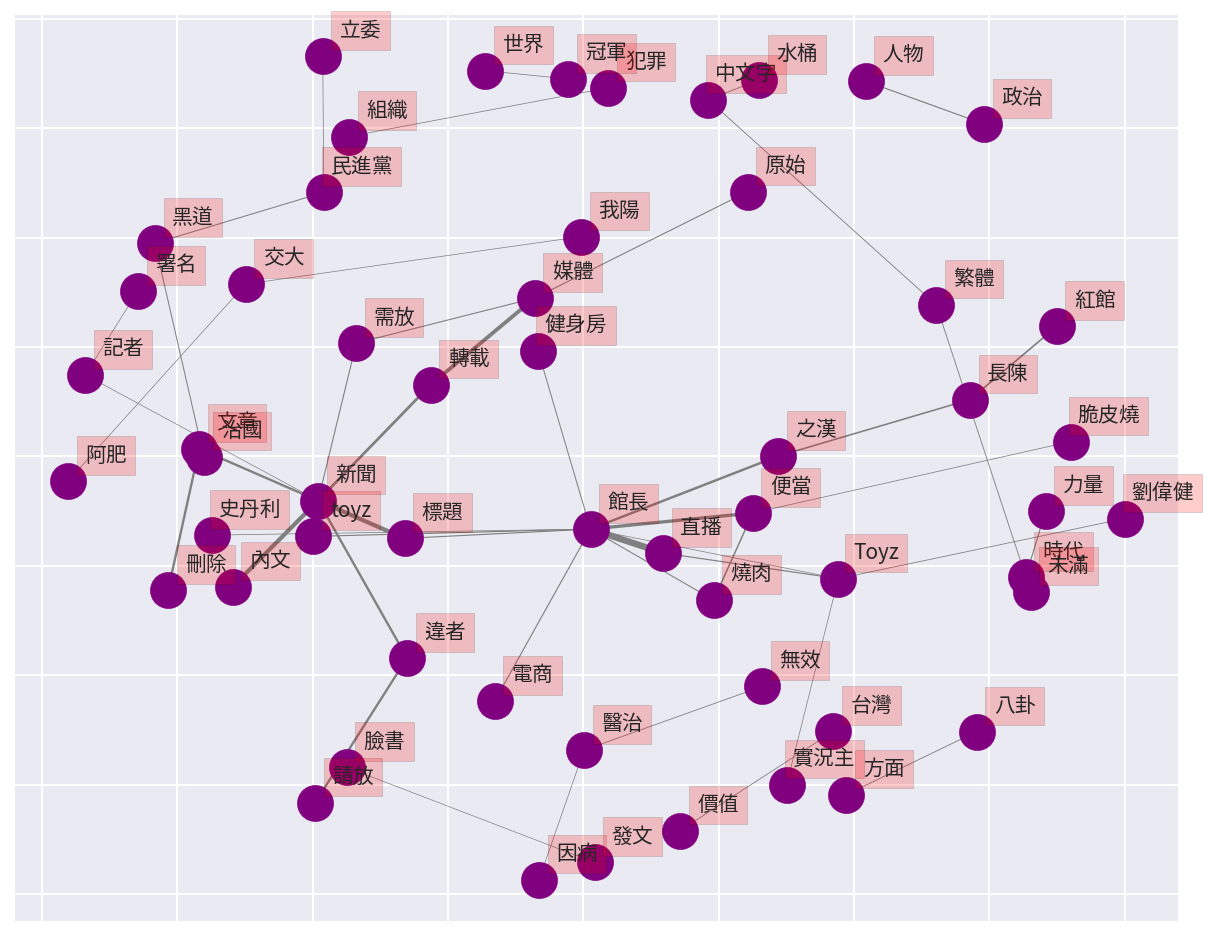

In [164]:
plt.rcParams['font.sans-serif'] = ['TaipeiSansTCBeta-Regular']

fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=10,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax
                )


# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.2),
            horizontalalignment='center', fontsize=10, fontproperties=fprop)

plt.show()

以館長為例，即便不認識館長，也能從相關圖中看出館長與直播、燒肉、便當、之漢等字詞有關，對於認識館長的人則可以整理出: 此事件討論到了館長的直播、賣220元的燒肉便當、館長的原名陳之漢，以及以大小寫分別都與館長連接的Toyz、toyz，可以推論出事件脈絡。  

### 8. Pairwise Correlation
計算兩個詞彙間的相關性 Phi相關係數(Phi coefficient)。

#### 8-1. 計算Phi coefficient

In [121]:
# 取常一起出現的bigram pair 前1500筆
b = {k:v for k,v in bigramfdist.most_common(1500)}
# b.items()

In [122]:
# 建立DataFrame
bigram_df = pd.DataFrame(list(b), columns=['word','word2']).assign(n=b.values())

In [123]:
# 每個bigram組合的次數
bigram_df.head()

word word2    n
0   館長    直播  311
1   記者    署名  202
2   新聞    標題  202
3   新聞    內文  201
4   轉載    媒體  184

In [178]:
# 計算各詞彙在各文章中出現的次數
word_count2 = noStop_df.groupby(['artUrl','word'],as_index=False).size()
word_count2.rename(columns={'size': 'count'},inplace=True)
word_count2.head(13)

artUrl  word  count
0   https://www.ptt.cc/bbs/Gossiping/M.1669824097....  2020      1
1   https://www.ptt.cc/bbs/Gossiping/M.1669824097....   623      1
2   https://www.ptt.cc/bbs/Gossiping/M.1669824097....    一步      1
3   https://www.ptt.cc/bbs/Gossiping/M.1669824097....    一遍      1
4   https://www.ptt.cc/bbs/Gossiping/M.1669824097....    共匪      1
5   https://www.ptt.cc/bbs/Gossiping/M.1669824097....    合理      1
6   https://www.ptt.cc/bbs/Gossiping/M.1669824097....    嘻嘻      1
7   https://www.ptt.cc/bbs/Gossiping/M.1669824097....    城府      1
8   https://www.ptt.cc/bbs/Gossiping/M.1669824097....    夢到      1
9   https://www.ptt.cc/bbs/Gossiping/M.1669824097....    太深      1
10  https://www.ptt.cc/bbs/Gossiping/M.1669824097....    對岸      1
11  https://www.ptt.cc/bbs/Gossiping/M.1669824097....    山羌      1
12  https://www.ptt.cc/bbs/Gossiping/M.1669824097....    強烈      1

In [184]:
#計算phi值
def phi_cor(phidf):
    # total x
    nx = len(set(word_count2[word_count2["word"]==phidf["word"]]["artUrl"]))
    tnx = len(df)-nx
    # total y
    ny = len(set(word_count2[word_count2["word"]==phidf["word2"]]["artUrl"]))
    tny = len(df)-ny
    # 有x 有y
    x_ls = list(word_count2[word_count2["word"]==phidf["word"]]["artUrl"]) #單獨有x
    y_ls = list(word_count2[word_count2["word"]==phidf["word2"]]["artUrl"]) #單獨有y
    nxy = len(set(x_ls)&set(y_ls)) #取交集
    # 有x 沒有y
    nxo = nx-nxy
    # 沒有x 沒有y
    uxy = set(x_ls)|set(y_ls) #取聯集
    noo = len(set(list(df["artUrl"]))-uxy) #取差集:全-有x有y
    # 沒有x 有y
    noy = ny-nxy
#     print(nx,ny,tny,tnx,nxy,noo,nxo,noy)
#     print(nx,ny,tny,tnx)
    if(math.sqrt(nx*ny*tny*tnx)==0): return 0
    phi = (nxy*noo-nxo*noy)/math.sqrt(nx*ny*tny*tnx)
    
    return phi

In [185]:
bigram_df["cor"] = bigram_df.apply(phi_cor, axis=1)
bigram_df = bigram_df[bigram_df["word"]!=bigram_df["word2"]]

In [186]:
bigram_df.head()

word word2    n       cor
0   館長    直播  311  0.096601
1   記者    署名  202  0.873601
2   新聞    標題  202  0.710255
3   新聞    內文  201  0.734357
4   轉載    媒體  184  0.830400

#### 8-2. 和 館長, toyz 相關性最高的 10 個詞彙

In [187]:
ice_sum = bigram_df[(bigram_df["word"]=="館長")].sort_values(by=['cor'], ascending = False).head(10)
taste_sum = bigram_df[(bigram_df["word"]=="toyz")].sort_values(by=['cor'], ascending = False).head(10)

/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


<Figure size 1800x1200 with 0 Axes>

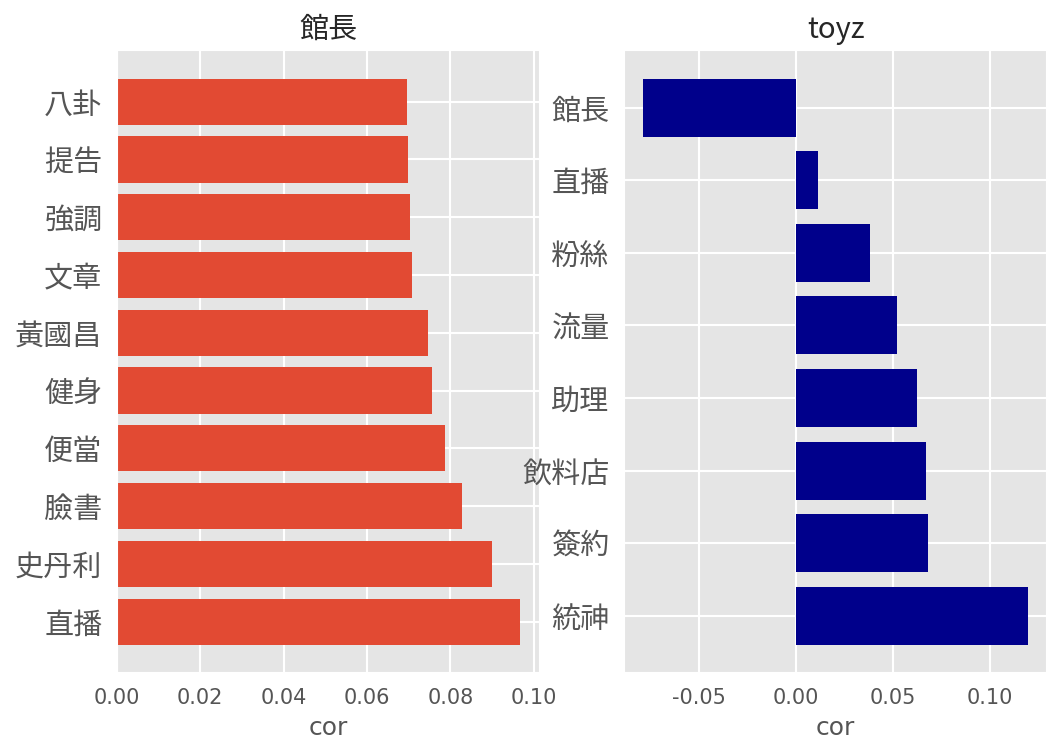

In [197]:
plt.rcParams['font.sans-serif'] = 'TaipeiSansTCBeta-Regular'
plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

fig, ax = plt.subplots(1, 2)
ax[0].set_title('館長', fontproperties=fprop)
ax[0].set_xlabel('cor')
ax[0].barh(ice_sum['word2'],ice_sum['cor'])
ax[0].set_yticklabels(ice_sum['word2'], fontproperties=fprop)

ax[1].set_title('toyz', fontproperties=fprop)
ax[1].set_xlabel('cor')
ax[1].barh(taste_sum['word2'],taste_sum['cor'],color="darkblue")
ax[1].set_yticklabels(taste_sum['word2'], fontproperties=fprop)


plt.show()

#### 8.3 使用詞彙關係圖畫出相關性大於0.4的組合

In [198]:
bigram_df[bigram_df["cor"]>0.4]

word word2    n       cor
1      記者    署名  202  0.873601
2      新聞    標題  202  0.710255
3      新聞    內文  201  0.734357
4      轉載    媒體  184  0.830400
6      新聞    轉載  132  0.706760
...   ...   ...  ...       ...
1468   看破    手腳    4  0.469979
1470   條例    修法    4  0.490435
1471  陳明文   寶和會    4  0.411192
1487   浮上    檯面    4  0.425180
1489   賣台  自古以來    4  0.632154

[296 rows x 4 columns]

In [199]:
word_cors = bigram_df[bigram_df["cor"]>0.4]
word_cors.reset_index(inplace=True, drop=True)

In [200]:
import networkx as nx
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(word_cors)):
    g.add_edge(word_cors["word"][i], word_cors["word2"][i], weight=word_cors["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*10 for w in  g.edges(data=True)]

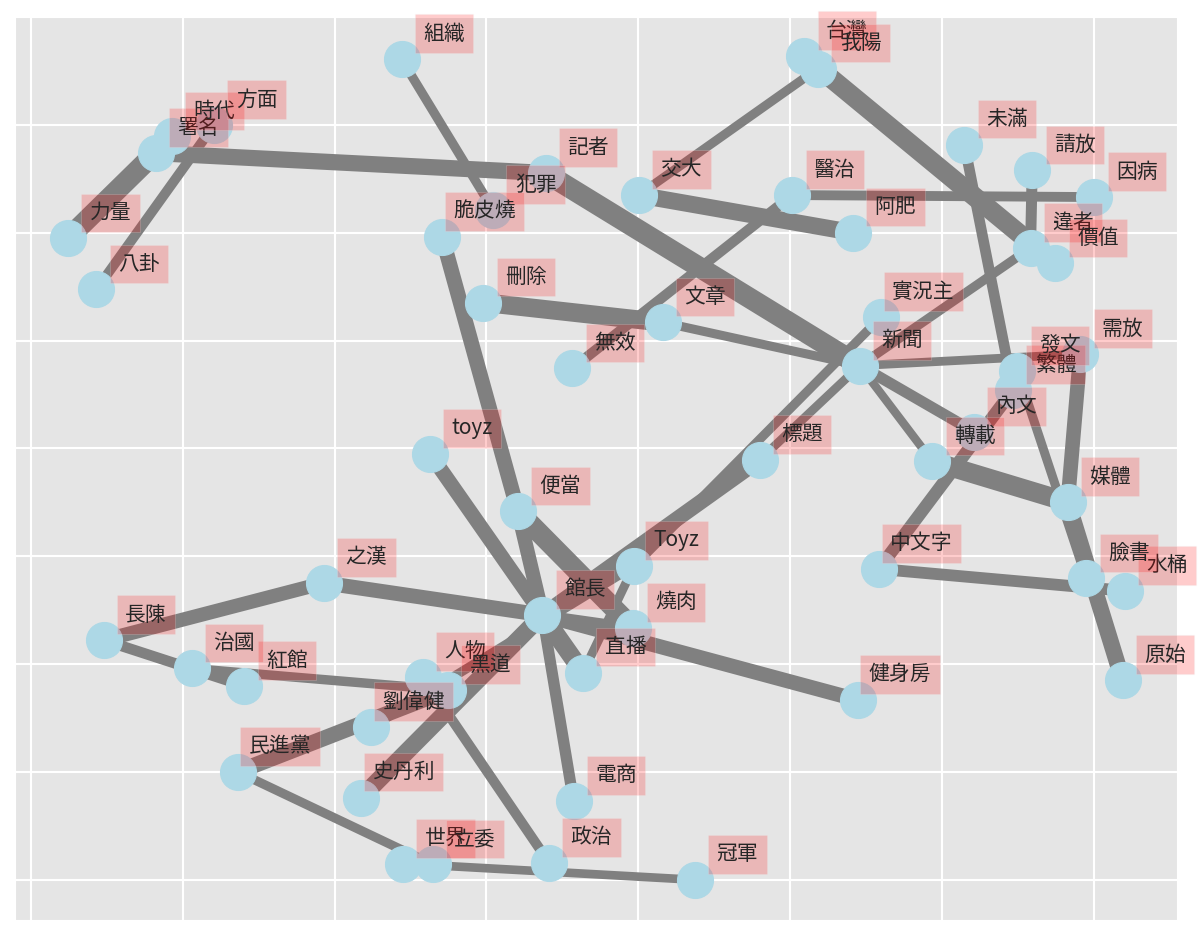

In [206]:
plt.rcParams['font.sans-serif'] = 'TaipeiSansTCBeta-Regular'
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=12,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.2),
            horizontalalignment='center', fontsize=10, fontproperties=fprop)
    
plt.show()

從相關性篩選過後的詞彙關係圖可以更聚焦到粗線聚集處: 館長，雖然事件由Toyz、館長共同起頭，但更多人談論的是有關於館長的人事物。  

### 9. 計算文章相似度

In [234]:
df.iloc[1000,:]

system_id                                                    1001
artUrl          https://www.ptt.cc/bbs/Gossiping/M.1672333534....
artTitle                                   [問卦]toyz不想被打為什麼找館長學格鬥？
artDate                                       2022-12-30 01:05:32
artPoster                                                    qm21
artCatagory                                             Gossiping
artContent      Toyz不想被打找館長學格鬥幹嘛\n他以為他可以跟賈克斯一樣有100%迴避嗎\n看館長以前的...
artComment      [{"cmtStatus": "推", "cmtPoster": "changzon", "...
e_ip                                                  61.231.2.83
insertedDate                                  2022-12-30 01:40:18
dataSource                                                    ptt
Name: 1000, dtype: object

In [222]:
data_cos= df.copy()
data_cos = data_cos.loc[:,["artTitle","artDate","artUrl","artContent"]]
# 需要改成使用空格連接斷好的詞
data_cos['word'] = data_cos.artContent.apply(getToken).map(' '.join)
data_cos.head(3)

artTitle              artDate  \
0  Re:[問卦]館長向全台最大黑道宣戰都不怕出事？  2022-12-01 00:01:35   
1       Re:[問卦]館長商品推薦什麼的八卦？  2022-12-01 00:31:49   
2    [新聞]館長開戰！直播公布「陳明文委員」電話  2022-12-01 08:51:54   

                                              artUrl  \
0  https://www.ptt.cc/bbs/Gossiping/M.1669824097....   
1  https://www.ptt.cc/bbs/Gossiping/M.1669825911....   
2  https://www.ptt.cc/bbs/Gossiping/M.1669855917....   

                                          artContent  \
0  我是想一件事很不明白\n照阿館所說\n對阿館開槍的背後真的是當今朝廷\n有點不合理呀\n\n...   
1  這還要用問，當然首推手錶啊\n\n粉絲讚不絕口可以留給下一代當傳家寶\nhttps://i....   
2  1.媒體來源:\n中時\n\n2.記者署名:\n黃朝郁\n\n3.完整新聞標題:\n館長開戰...   

                                                word  
0  明白 照阿館 阿館 開槍 背後 當今 朝廷 合理 2020 芒果乾 賣到 缺貨 阿館 搞過 ...  
1  用問 首推 手錶 粉絲 讚不絕口 留給 下一代 傳家寶 https imgur com h0...  
2  媒體 中時 記者 署名 朝郁 新聞 標題 館長 開戰 直播 公布 陳明文 委員 電話 上凱道...

In [236]:
# Bag of Word
# 篩選至少出現在5篇文章以上的詞彙
vectorizer = CountVectorizer(min_df=5)
X = vectorizer.fit_transform(data_cos["word"])
vocabulary = vectorizer.get_feature_names()
# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

00  003  01  02  03  04  05  06  07  08  ...  黨內  黨員  黨團  黨媒  黨派  黨部  \
0      0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
1      0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
2      0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   1   
3      0    0   1   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   
4      0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
...   ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..   
3146   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
3147   1    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
3148   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
3149   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
3150   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   

      鼎泰豐  鼓勵  鼻子  龐大  
0       0   0   0   0  
1       0   0   0   0  
2       0   0   0   0  
3       0   0   0   0  
4       0   0   0   0  
...   ...  ..  ..  ..  
3146    0   0   0   0  
3147    0   0   0   0  
3148    0   0   0   0  
3149    0   0   0   0  
3150    0   0   0   0  

[3151 rows x 5395 columns]

In [237]:
transformer = TfidfTransformer()  
print(transformer) 
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  
# print(tfidf.toarray())

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
TFIDF_df

TfidfTransformer()


00  003        01   02   03   04   05   06   07        08  ...  \
0     0.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   
1     0.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   
2     0.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   
3     0.000000  0.0  0.091384  0.0  0.0  0.0  0.0  0.0  0.0  0.093193  ...   
4     0.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   
...        ...  ...       ...  ...  ...  ...  ...  ...  ...       ...  ...   
3146  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   
3147  0.141481  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   
3148  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   
3149  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   
3150  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   

       黨內   黨員   黨團   黨媒   黨派        黨部  鼎泰豐   鼓勵   鼻子   龐大  
0     0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  
1     0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  
2     0.0  0.0  0.0  0.0  0.0  0.064884  0.0  0.0  0.0  0.0  
3     0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  
4     0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  
...   ...  ...  ...  ...  ...       ...  ...  ...  ...  ...  
3146  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  
3147  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  
3148  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  
3149  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  
3150  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  

[3151 rows x 5395 columns]

In [238]:
# 計算 cosine_similarity
def cosine_similarity(vector):
    cos_list = []
    for i in tfidf.toarray():
        score = np.dot(vector, i)  / (norm(vector) * norm(i))
        cos_list.append(score)
    df = pd.DataFrame(cos_list, columns=["cos_similarity"])
    return df

In [239]:
print(tfidf.toarray()[1])
cos_df = cosine_similarity(tfidf.toarray()[1])

[0. 0. 0. ... 0. 0. 0.]


/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


In [240]:
# 第一篇文章和其他文章的相似程度
cos_df.head(10)

cos_similarity
0        0.000000
1        1.000000
2        0.043078
3        0.000000
4        0.000000
5        0.000000
6        0.000000
7        0.074130
8        0.000000
9        0.016277

In [241]:
cos_df = cos_df.merge(data_cos, how = 'left', left_index=True, right_index=True)
# cos_df.head()
cos_df.loc[:,["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

cos_similarity                           artTitle  \
1           1.000000                Re:[問卦]館長商品推薦什麼的八卦？   
900         0.450098              [問卦]Toyz在成吉思汗快被打死了？！！   
2006        0.432492                    [問卦]館長餐盒蠻多人排隊的啊   
2572        0.415760                     [爆卦]驚館長健身房違建？！   
2837        0.394897           [問卦]TOYZ:男生互相來互相去蠻嚴重我恐同！   
1193        0.354746               [問卦]有一說一，館長的便當價格不算貴吧   
2136        0.350354                 [問卦]松屋的套餐vs館長脆皮燒肉飯   
1713        0.329559                       [問卦]館長便當份量升級   
409         0.329300  Re:[新聞]鄭家純道歉了！稱「館長要穿防彈背心出門」：並非惡意嘲   
888         0.324359                  Re:[問卦]為什麼圖書館需要行銷   

                                                 artUrl  
1     https://www.ptt.cc/bbs/Gossiping/M.1669825911....  
900   https://www.ptt.cc/bbs/Gossiping/M.1672308706....  
2006  https://www.ptt.cc/bbs/Gossiping/M.1679106523....  
2572  https://www.ptt.cc/bbs/Gossiping/M.1680526467....  
2837  https://www.ptt.cc/bbs/Gossiping/M.1681104413....  
1193  https://www.ptt.cc/bbs/Gossiping/M.1673081592....  
2136  https://www.ptt.cc/bbs/Gossiping/M.1679378732....  
1713  https://www.ptt.cc/bbs/Gossiping/M.1678200962....  
409   https://www.ptt.cc/bbs/Gossiping/M.1670811803....  
888   https://www.ptt.cc/bbs/Gossiping/M.1672281158....

In [246]:
df.loc[900, 'artUrl']

'https://www.ptt.cc/bbs/Gossiping/M.1672308706.A.E31.html'

藉此，即使是對於「館椅之戰」沒有先備知識，也可以從列出的文章找與此主題最相關的文章。  
以第900篇「[問卦]Toyz在成吉思汗快被打死了？！！」為例，此貼文正是介紹館椅之戰的起頭: Toyz在訓練中被館長打倒在地，內容負面且較為偏激，反映出我們的情緒分析: 負面。

## D. 結論

我們可以從以上分析發現一個現象: 雙方怒氣中的爭論以及在網友的起鬨下，會造成爭論的異議逐漸偏離軌道，甚至往最能傷害對方、卻不是爭論重點的方向偏離，一開始的起頭是館長下手過重、Toyz口不擇言，解決爭執的方法很明確，所以謂旁觀者清當局者迷，又或者此事件只是網紅知名度的炒作手法之一罷了。